# Projet 6 : Classifiez automatiquement des biens de consommation

 La mission est de réaliser une première étude de faisabilité d'un moteur de classification d'articles basé sur une image et une description pour l'automatisation de l'attribution de la catégorie de l'article.

- L'objectif est d'analyser  le jeu de données en réalisant un prétraitement des images et des descriptions des produits, une réduction de dimension, puis un clustering. Les résultats du clustering seront présentés sous la forme d’une représentation en deux dimensions à déterminer, qui ’illustrera le fait que les caractéristiques extraites permettent de regrouper des produits de même catégorie.


# Données textuelles

Ce notebook est consacré à la partie texte (NLP) du projet.

### Imports et chargements des données

In [38]:
import time
from datetime import timedelta, datetime, tzinfo, timezone
from urllib import request
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

from matplotlib import pyplot, transforms
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.word2vec import Word2Vec


from matplotlib.patches import Polygon
import IPython.display
from IPython.display import display


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

from sklearn.metrics import davies_bouldin_score, silhouette_score
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score

from ipywidgets import IntProgress
from ipywidgets import Text



from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import warnings
warnings.filterwarnings('ignore')
sns.set()

In [39]:
file_path = '/Users/admin/Desktop/formation_data_Scientist/projet6/Donnees/'

In [40]:
df = pd.read_csv(file_path + 'flipkart_com-ecommerce_sample_1050.csv')

In [41]:
df['product_category_tree'][0]

'["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'

In [42]:
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [44]:
df['uniq_id'].duplicated().sum()

0

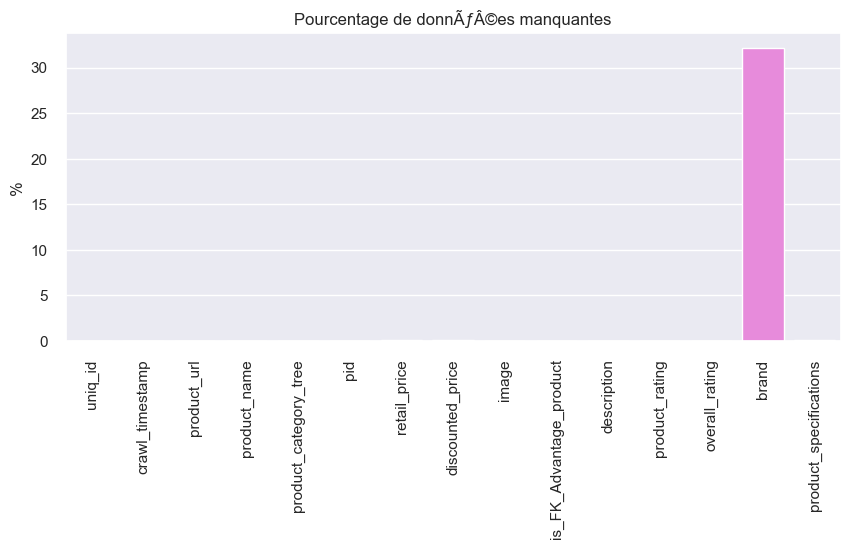

In [45]:
# Calcul du nombre de valeurs manquantes par colonne
df_na = df.isna().sum()/len(df)*100
# Affichage graphique
fig = plt.figure(1, figsize=(10, 4))
sns.barplot(x=df_na.index, y=df_na.values)
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel("%")
plt.title("Pourcentage de donnÃƒÂ©es manquantes")
plt.show()

### Nettoyage catégories

In [46]:
ln = []
liste_1 = []
data = pd.DataFrame({})
for i in df.index:
    df_i = df['product_category_tree'][i].split("\"")[1].split("\"")[0].strip()
    df_i = df_i.split(">>")
    #ln = ln.append(len(df_i))
    size_tab_str = len(df_i)
    max_depth = 7
    tup_str = [df_i[j].strip() if j<size_tab_str else "" \
                     for j in np.arange(max_depth)]
    liste_1.append(tup_str)
    #print(tup_str[0])
data = pd.DataFrame(data = liste_1, columns  = ['categ'+ str(k) for k in range(7)])
    #for j in range(0,6,1): 

In [47]:
data['categ0'].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

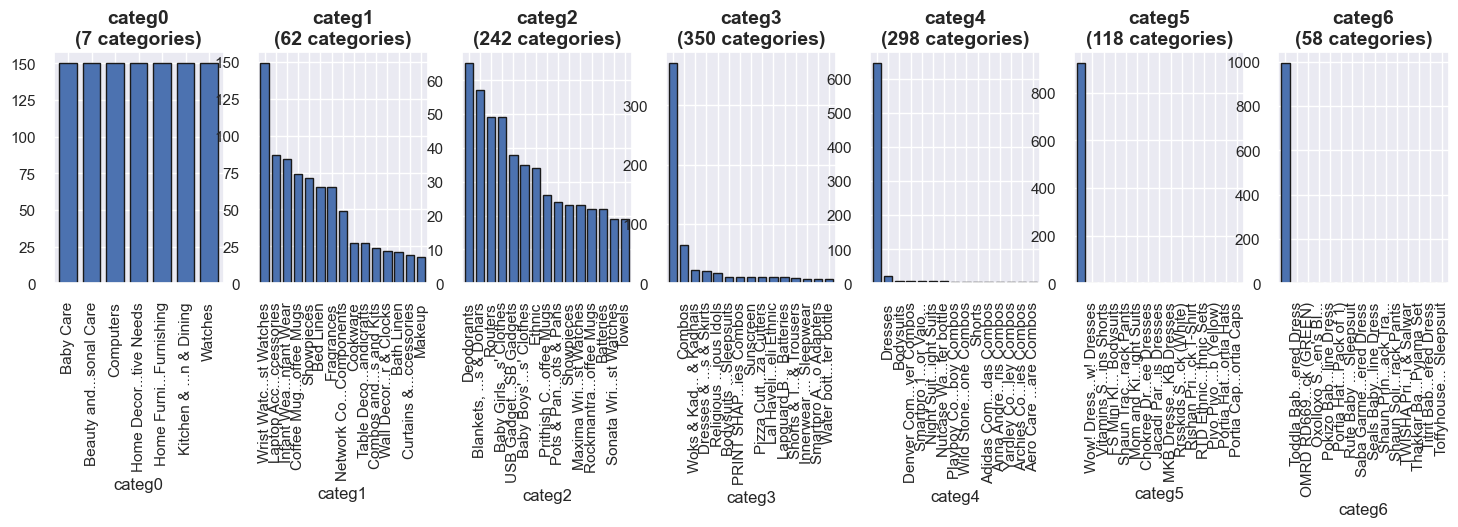

In [48]:
shorten_label = 10
n_first = 15
fig = plt.figure(figsize=(18,3))
for i, col in enumerate(data.columns,1):
    # plot graph
    ax = fig.add_subplot(1,len(data.columns), i)
    ser = data.groupby(col).size().sort_values(ascending=False)
    ser[0:n_first].plot.bar(width=0.75, ec='k', ax=ax)
    # les étiquettes
    thr = int(shorten_label)
    lab_x = [item.get_text() for item in ax.get_xticklabels()]
    short_lab_x = [s[:thr]+'...'+s[-thr:] if len(s)>thr else s for s in lab_x]
    ax.axes.set_xticklabels(short_lab_x)
    # le titre
    ax.set_title(col+f'\n({ser.shape[0]} categories)', fontweight='bold',size=14)

In [49]:
data['uniq_id'] = df['uniq_id']

In [50]:
df = pd.merge(df, data,
                    how="left",
                    on="uniq_id")

In [51]:
df

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,...,overall_rating,brand,product_specifications,categ0,categ1,categ2,categ3,categ4,categ5,categ6
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,...,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet ...,,,
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,...,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red,...",,
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,...,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE ...,,
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,...,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King size...,,
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,...,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double B...,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,...,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,Baby & Kids Gifts,Stickers,Oren Empower Stickers,,,
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,...,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,Baby & Kids Gifts,Stickers,Wallmantra Stickers,,,
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,...,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=

In [52]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/admin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [53]:
tokenizer = nltk.RegexpTokenizer(r'\w+')
tokenizer.tokenize("Bonjour, je suis un texte d'exemple pour le cours d'Openclassrooms. Soyez attentifs à ce cours !")

['Bonjour',
 'je',
 'suis',
 'un',
 'texte',
 'd',
 'exemple',
 'pour',
 'le',
 'cours',
 'd',
 'Openclassrooms',
 'Soyez',
 'attentifs',
 'à',
 'ce',
 'cours']

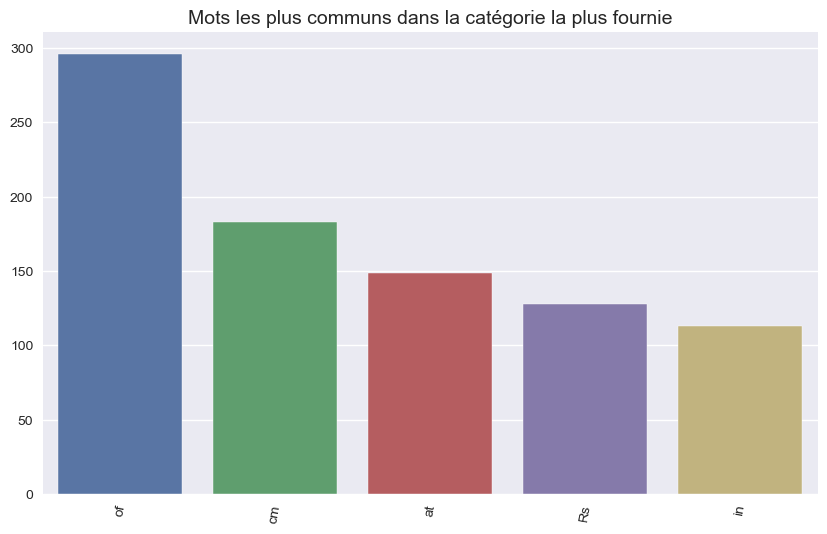

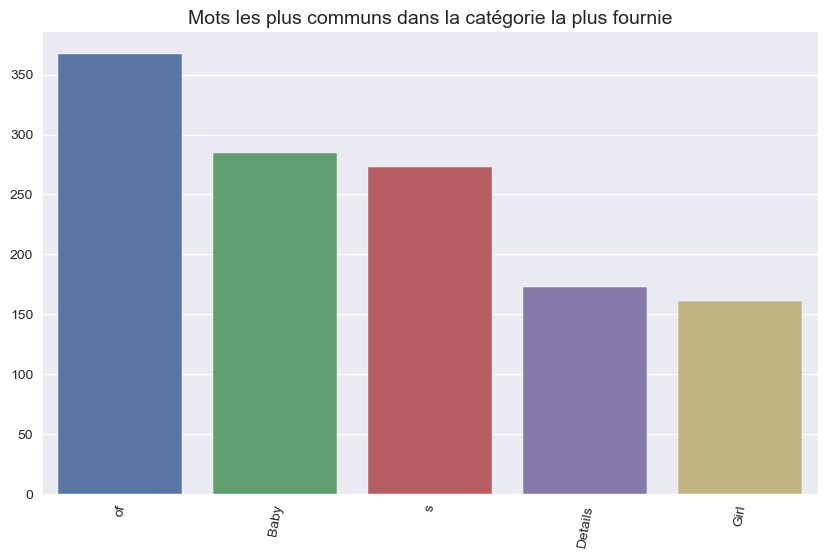

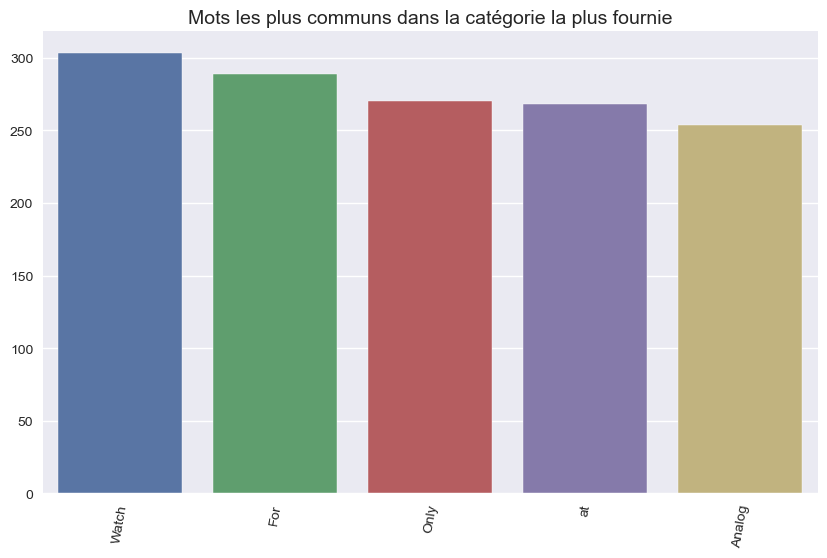

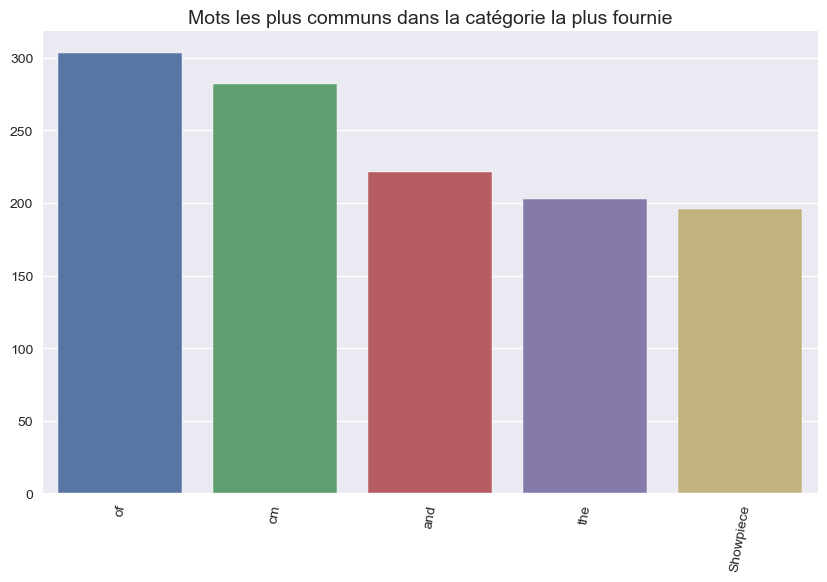

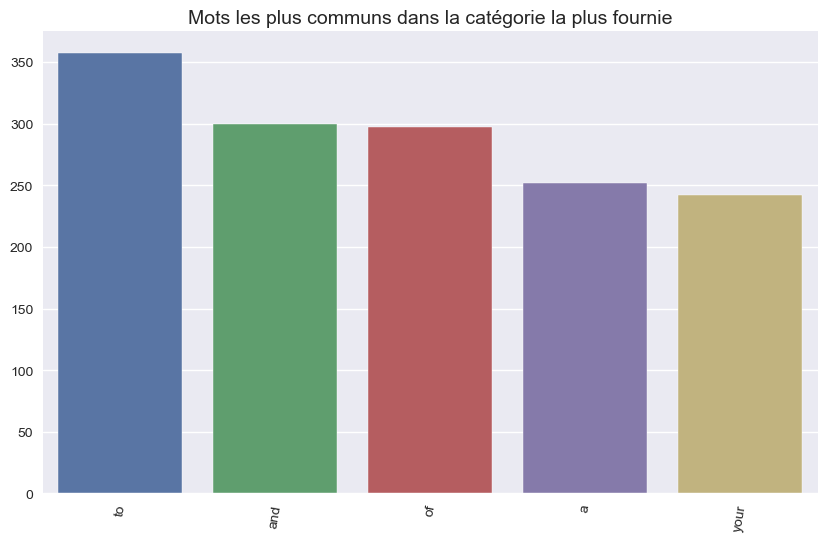

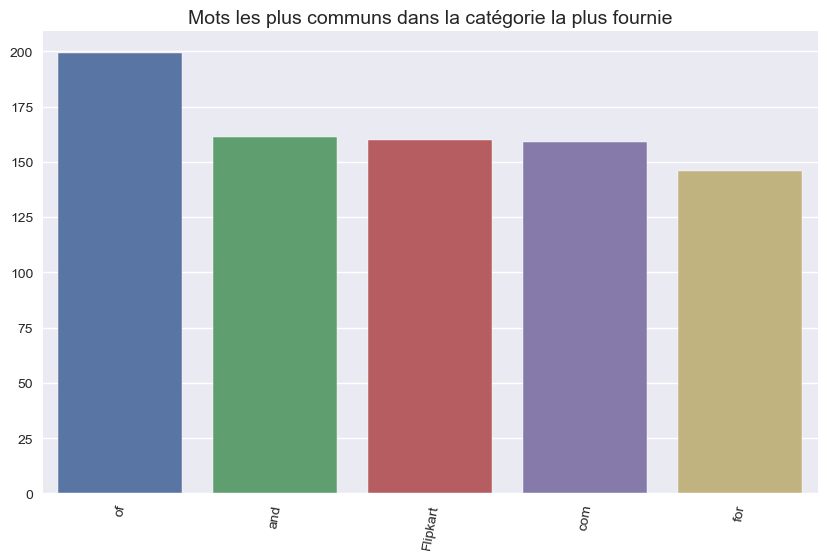

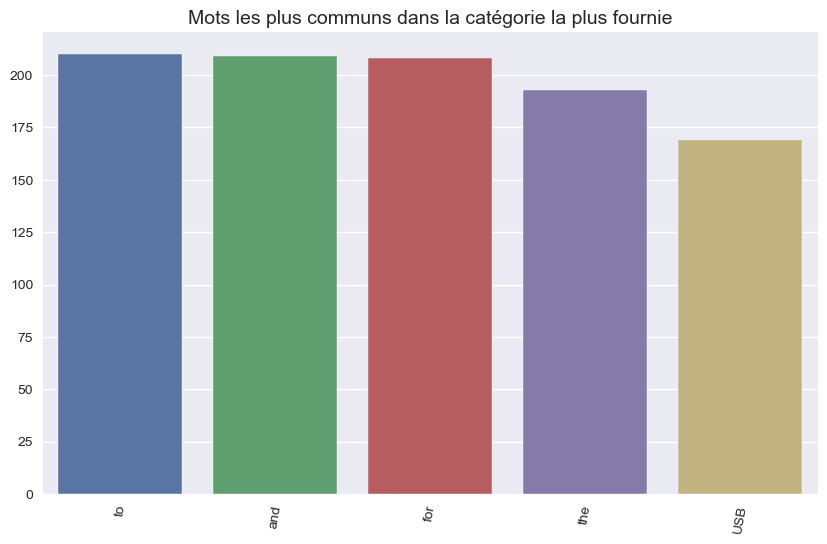

In [54]:
from collections import Counter
for categ in df["categ0"].unique().tolist():
    #capword_tokenizer = RegexpTokenizer("[A-Z]\w+")
    capword_tokenizer = nltk.RegexpTokenizer(r'\w+')
#df["categ0"] = df["categ0"].str.strip()
    des = df[df["categ0"] == categ]

# On récupère toutes les descriptions de la catégorie
# On en forme une chaîne de caractères
    des_text = ' '.join(text for text in des["description"])

# On fait une tokenisation de cete chaine
# avec le tokenizer construit précédemment
# On ne garde que les mots capitalisés
    des_text_tokenized = capword_tokenizer.tokenize(des_text)

# On recrée une chaîne "propre"
    des_text_tokenized = ' '.join(des_text_tokenized)



    des_list = des_text_tokenized.split()
    des_counts = Counter(des_list)
    des_common_words = [word[0] for word in des_counts.most_common(5)]
    des_common_counts = [word[1] for word in des_counts.most_common(5)]

    plt.style.use('seaborn')
    plt.figure(figsize=(10, 6))
    plt.xticks(rotation=80)
    sns.barplot(x=des_common_words, y=des_common_counts)
    plt.title("Mots les plus communs dans la catégorie la plus fournie", size=14)

In [55]:
df['description'].head()

0    Key Features of Elegance Polyester Multicolor ...
1    Specifications of Sathiyas Cotton Bath Towel (...
2    Key Features of Eurospa Cotton Terry Face Towe...
3    Key Features of SANTOSH ROYAL FASHION Cotton P...
4    Key Features of Jaipur Print Cotton Floral Kin...
Name: description, dtype: object

In [56]:
#texte = df['description'][2]
#print(texte)
#print('-'*50)
#print(nettoyage_document(texte, stemmed=False, output='T'))

In [62]:
def description_sentences(data, tokenizer, remove_stopwords=False):
    # 1. Using nltk tokenizer (trailing whitespaces are removed)
    raw_sentences = tokenizer.tokenize(data.strip())
    sentences = []
    # 2. Loop for each sentence
    for raw_sentence in raw_sentences:
        if len(raw_sentence)>0:
            sentences.append(nettoyage_document(raw_sentence,\
                                                  remove_stopwords))

    # This returns the list of lists
    return sentences

In [63]:
descriptions_w2v = df['description'].copy().map(
    lambda texte: nettoyage_document(texte, stemmed=False, output='tokens'))

In [61]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [64]:
def affiche_liste(liste):
    return liste

## Prétraitements et clustering 


### Extraction des features: TfidfVectorizer et bag of words 

In [65]:
X = {"max_df": [0.1, 0.2, 0.5, 0.8, 0.9], # ignore terms that appear in more than max_df*100% of the documents
"min_df": [1, 3, 5, 8, 10]}

In [66]:
''' cette fonction permettant lextraction des features des données textuelles
en utilisant les models TfidfVectorizer et bag of words. Les features textuelles seront par la suite
concatinés avec la variable de la variable cible'''

def process(model, df, target, var_use_to_pred):
    
    matrix = model.fit_transform(df[var_use_to_pred])

    # Standardisation.
    Std = StandardScaler()
    matrix_standard = Std.fit_transform(matrix.toarray())
    df_description_matrix_standard = pd.DataFrame(matrix_standard)

    df_des_target = pd.concat([df_description_matrix_standard, df[target]], axis=1)

    # Split en training/testing set.
    #df_train = df2.drop(ta)
    X_train, X_test, Y_train, Y_test = train_test_split(df_des_target .drop(target, axis = 1), 
                                                    df_des_target[target], 
                                                test_size=0.2)
    return X_train, X_test, Y_train, Y_test, df_description_matrix_standard 
#P_score.append(precision_score(Y_test, prediction, average='weighted'))
#print(accuracy_score(X_train, Y_train))

#### TfidfVectorizer: Définition

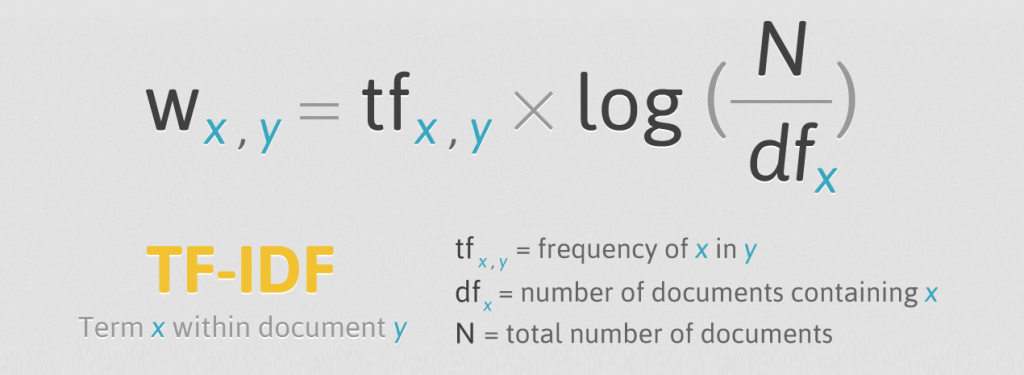

In [179]:
from IPython.display import display, Image
path = '/Users/admin/Desktop/tfidf.png'
display(Image(path, filename=path))

Cette mesure statistique permet d'évaluer l'importance d'un terme contenu dans un document, relativement à une collection ou un corpus. Le poids augmente proportionnellement au nombre d'occurrences du mot dans le document. Il varie également en fonction de la fréquence du mot dans le corpus.

In [25]:
vectorizer_tfidf = TfidfVectorizer(strip_accents='unicode', 
                    lowercase=True,
                    stop_words='english',
                    analyzer='word')
#description_matrix = tfidf.fit_transform(df['description'])

#### Bag-of-words : Définition

Le bag-of-words consiste à créer une colonne pour chaque mot différent présent pour l'ensemble des textes et d'indiquer le nombre de fois qu'il apparait dans chaque texte. L'histogramme associé consiste à indiquer la fréquence normalisé de l'apparition de chacun des mots dans chaque texte pour l'ensemble du corpus de textes.

In [26]:
vectoriser = CountVectorizer(max_df=0.2,
                                      min_df=0.05, 
                                      stop_words='english',
                                      lowercase=True)

In [28]:
vectoriser_BOW = CountVectorizer(max_df=0.2,
                                      min_df=0.05, 
                                      stop_words='english',
                                      lowercase=True)
X_train, X_test, Y_train, Y_test, df_description_matrix_standard_BOW = process(model = vectoriser, df = df, target = 'categ0', var_use_to_pred = 'description')

In [29]:
df_description_matrix_standard_BOW

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,68
0,2.365865,-0.294884,-0.374303,-0.278598,-0.217458,-0.202548,2.032926,-0.221249,1.620275,-0.280631,...,2.124328,-0.246338,-0.199306,-0.239340,-0.353432,-0.233702,-0.262232,-0.294443,-0.272064,-0.237975
1,-0.213739,-0.294884,-0.374303,-0.278598,-0.217458,3.342040,-0.209272,2.331622,1.620275,-0.280631,...,-0.248592,-0.246338,-0.199306,-0.239340,-0.353432,-0.233702,-0.262232,2.047720,1.783093,1.934839
2,4.945468,-0.294884,-0.374303,-0.278598,-0.217458,-0.202548,-0.209272,2.331622,1.620275,4.589819,...,-0.248592,1.983449,-0.199306,5.650662,-0.353432,1.447032,2.437219,2.047720,1.783093,-0.237975
3,-0.213739,-0.294884,-0.374303,-0.278598,-0.217458,-0.202548,-0.209272,-0.221249,1.620275,2.154594,...,-0.248592,-0.246338,-0.199306,1.723994,-0.353432,-0.233702,-0.262232,6.732047,-0.272064,1.934839
4,4.945468,-0.294884,-0.374303,-0.278598,-0.217458,-0.202548,-0.209272,-0.221249,1.620275,2.154594,...,-0.248592,-0.246338,0.637779,-0.239340,-0.353432,-0.233702,2.437219,6.732047,-0.272064,1.934839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,-0.213739,-0.294884,-0.374303,-0.278598,-0.217458,-0.202548,-0.209272,-0.221249,-0.459540,-0.280631,...,-0.248592,4.213235,-0.199306,-0.239340,-0.353432,-0.233702,-0.262232,-0.294443,-0.272064,-0.237975
1046,-0.213739,-0.294884,-0.374303,-0.278598,-0.217458,-0.202548,-0.209272,-0.221249,-0.459540,-0.280631,...,-0.248592,4.213235,-0.199306,-0.239340,-0.353432,-0.233702,-0.262232,4.389883,-0.272064,-0.237975
1047,-0.213739,-0.294884,-0.374303,-0.278598,-0.217458,-0.202548,-0.209272,-0.221249,-0.459540,-0.280631,...,-0.248592,-0.246338,-0.199306,-0.239340,-0.353432,-0.233702,-0.262232,-0.294443,-0.272064,-0.237975
1048,-0.213739,-0.294884,-0.374303,-0.278598,-0.217458,-0.202548,-0.209272,-0.221249,-0.459540,-0.280631,...,-0.248592,-0.246338,-0.199306,-0.239340,-0.353432,-0.233702,-0.262232,-0.294443,-0.272064,-0.237975


### Clustering supervisé et affichage du score

#### calcul de l'accuracy score

In [68]:
'''cette fonction permet d'afficher le accuracy score sur le jeu d'entrainemnt ainsi que le jeu de test. Elle permet égalemet
d'afficher un datatframe de comparaison entre les catégories réelles et prédits. Ce dataframe sera utiliser après 
pour afficher la matrice de confusion.'''

max_features_test = [500,1000,2000, 5000]

test_score = []
train_score = []
P_score = []

def score(gridSearch, model, df, target , var_use_to_pred):
    
    
#Création du jeu d'entrainement et de test    
    X_train, X_test, Y_train, Y_test, df_description_matrix_standard = process(model, df, target , var_use_to_pred)
    
# Fit sur le training set.
    df_y_test = pd.DataFrame(Y_test)
    gridSearch.fit(X_train, Y_train)
#Prédiction des catégories à partir des données textuelles
    Y_pred = gridSearch.best_estimator_.predict(X_test)
    
    df_y_predict = pd.DataFrame(Y_pred)
    df_y_test.reset_index(inplace = True, drop = True)
#création du dataset de comparaison
    df_compare = pd.concat([df_y_test, df_y_predict], axis=1)
    df_compare.columns = ['product_category', 'prediction']
#affichage e l'accuracy_score
    
    print(gridSearch.best_estimator_)
    score_train = accuracy_score(gridSearch.best_estimator_.predict(X_train), Y_train)
    score_test = accuracy_score(Y_test, Y_pred)
    test_score.append(score_test)
    train_score.append(score_train)
    P_score.append(precision_score(Y_test, Y_pred, average='weighted'))
    
    
    print(score_train)
    print(score_test)
    print(P_score)
    return test_score, train_score, P_score, df_compare

In [538]:
#tfidf = TfidfVectorizer(
                         #  strip_accents='unicode', 
                       # lowercase=True,
                        #stop_words='english',
                       # analyzer='word')
#test_score, train_score, P_score , df_compare = score(gridSearch, model = tfidf, df = df, 
                                           #  target = 'categ0',
                                             #var_use_to_pred = 'description')

In [69]:
from sklearn.linear_model import LogisticRegression

### Affichage du score

In [70]:
models = {'SVC': SVC(), 'LogisticRegression': LogisticRegression(),'RandomForestClassifier': RandomForestClassifier()}
params = {'C' : [0.01, 0.1, 0.5, 0.9, 1, 1.1]}
params_grid = {'max_depth': range(3,6), 'n_estimators': (200,300,500)}

In [71]:
from sklearn.metrics import confusion_matrix
def affiche_score(vectoriser):
    j = 0
    for name_model, model1 in models.items():
        #test_score = []
        #train_score = []
        #P_score = []
        print(name_model)
        #RForestClassifier = RandomForestClassifier()
        if name_model == 'RandomForestClassifier':
            gridSearch = GridSearchCV(model1,params_grid, cv=5,  
                                               scoring='accuracy')
        else:
            gridSearch = GridSearchCV(model1, params, cv=5,  
                                               scoring='accuracy')
        
        
        for i in max_features_test:
            
            tfidf = vectoriser(max_df=0.995,
                                      min_df=0.05,
                                      max_features=i, 
                                      stop_words='english',
                                      lowercase=True)
           
            test_score, train_score, P_score, df_compare = score(gridSearch, model = tfidf, df = df, 
                                             target = 'categ0',
                                             var_use_to_pred = 'description')
            
            print('le nombre des features est', i)
            
        list_categ = df['categ0'].unique()
        mat_conf = confusion_matrix(df_compare['product_category'], df_compare['prediction'], labels = list_categ)
# Mise sous forme de DataFrame
        mat_conf_df = pd.DataFrame(mat_conf,  index=list_categ, columns=list_categ)
        plt.figure(figsize=(8,6))
        sns.heatmap(mat_conf_df,
        xticklabels=True, 
        yticklabels= True, 
        annot=True,
        cmap="plasma", cbar=False,
        annot_kws={"size": 15, 'weight' : 'bold'})
#sns.heatmap(mat_conf_df, annot=True, linewidths=.3)
        plt.ylabel('Product Categories')
        plt.xlabel('Clusters')
        
            
        print('les dimensions sont:',len(train_score))
        
            
        plt.figure(figsize=(12,8))
        axes = plt.gca()
        plt.title("Evolution de l'accuracy & de la précision suivant le nbr de mot", weight='bold', size=20)
        plt.xlabel('Nombre de mot pour le TfidfVectorizer', weight='bold', size=17)
        plt.ylabel('Accuracy_score', weight='bold', size=17)
        axes.set_ylim(0.5, 1)
        sns.lineplot(x=max_features_test, y=train_score[j:j+len(max_features_test)],  color='b', marker='o')
        sns.lineplot(x=max_features_test, y=test_score[j:j+len(max_features_test)],  color='r', marker='o')
        sns.lineplot(x=max_features_test, y=P_score[j:j+len(max_features_test)],  color='g', marker='o')
        
#tfidf = TfidfVectorizer(stop_words='english',lowercase=True)
#test_score, train_score, P_score, df_compare = score(gridSearch, model = tfidf, df = df, 
                                            # target = 'categ0',
                                             #var_use_to_pred = 'description')
       
        plt.show()
        j = j+len(max_features_test)
    return plt.show()

#### Affichage du score pour TfidfVectorizer

SVC
SVC(C=1.1)
0.9285714285714286
0.8714285714285714
[0.8871499708868129]
le nombre des features est 500
SVC(C=1.1)
0.9285714285714286
0.8761904761904762
[0.8871499708868129, 0.8853680659255573]
le nombre des features est 1000
SVC(C=1.1)
0.9297619047619048
0.861904761904762
[0.8871499708868129, 0.8853680659255573, 0.8676379271161055]
le nombre des features est 2000
SVC(C=1)
0.930952380952381
0.8666666666666667
[0.8871499708868129, 0.8853680659255573, 0.8676379271161055, 0.8843854427985757]
le nombre des features est 5000
les dimensions sont: 4


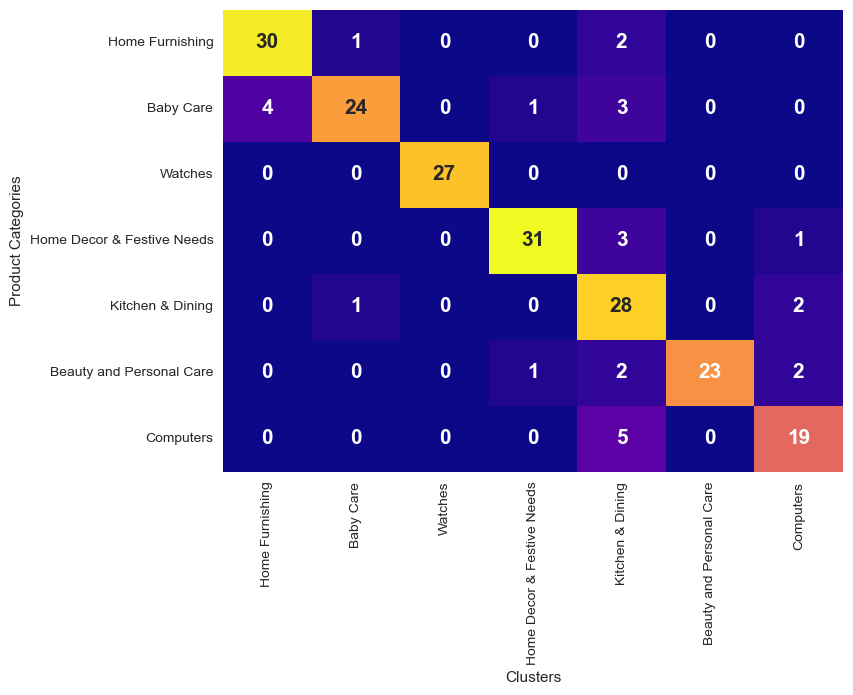

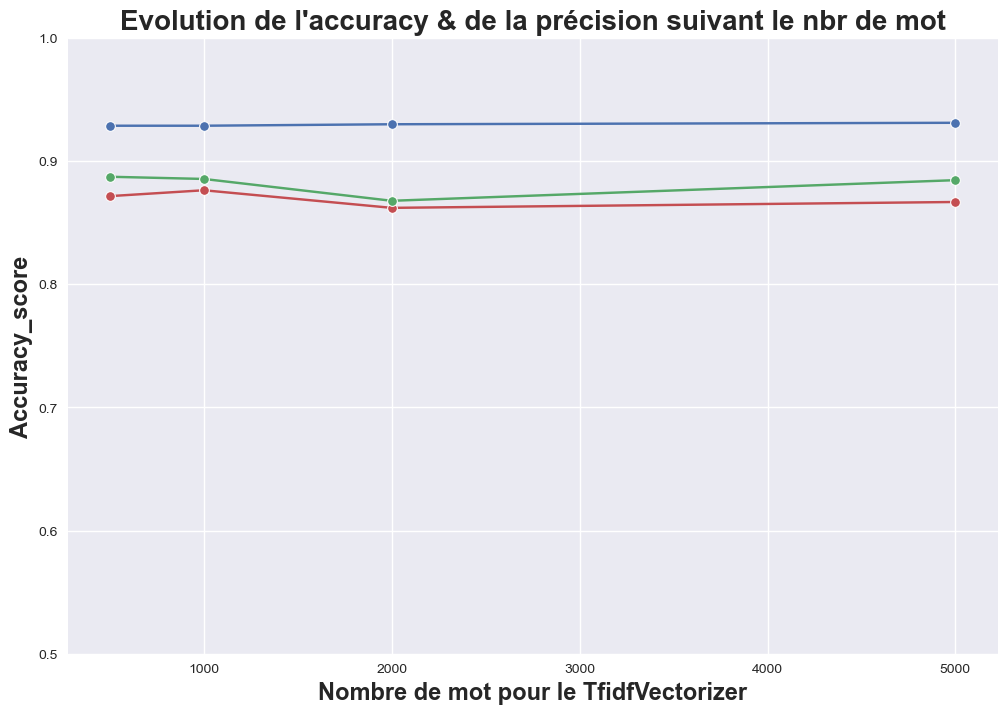

LogisticRegression
LogisticRegression(C=0.1)
0.9297619047619048
0.8142857142857143
[0.8871499708868129, 0.8853680659255573, 0.8676379271161055, 0.8843854427985757, 0.8301887070617722]
le nombre des features est 500
LogisticRegression(C=0.1)
0.9166666666666666
0.8714285714285714
[0.8871499708868129, 0.8853680659255573, 0.8676379271161055, 0.8843854427985757, 0.8301887070617722, 0.8820244129297317]
le nombre des features est 1000
LogisticRegression(C=0.5)
0.9333333333333333
0.8333333333333334
[0.8871499708868129, 0.8853680659255573, 0.8676379271161055, 0.8843854427985757, 0.8301887070617722, 0.8820244129297317, 0.8373156623442666]
le nombre des features est 2000
LogisticRegression(C=0.1)
0.9297619047619048
0.8428571428571429
[0.8871499708868129, 0.8853680659255573, 0.8676379271161055, 0.8843854427985757, 0.8301887070617722, 0.8820244129297317, 0.8373156623442666, 0.8793431299882914]
le nombre des features est 5000
les dimensions sont: 8


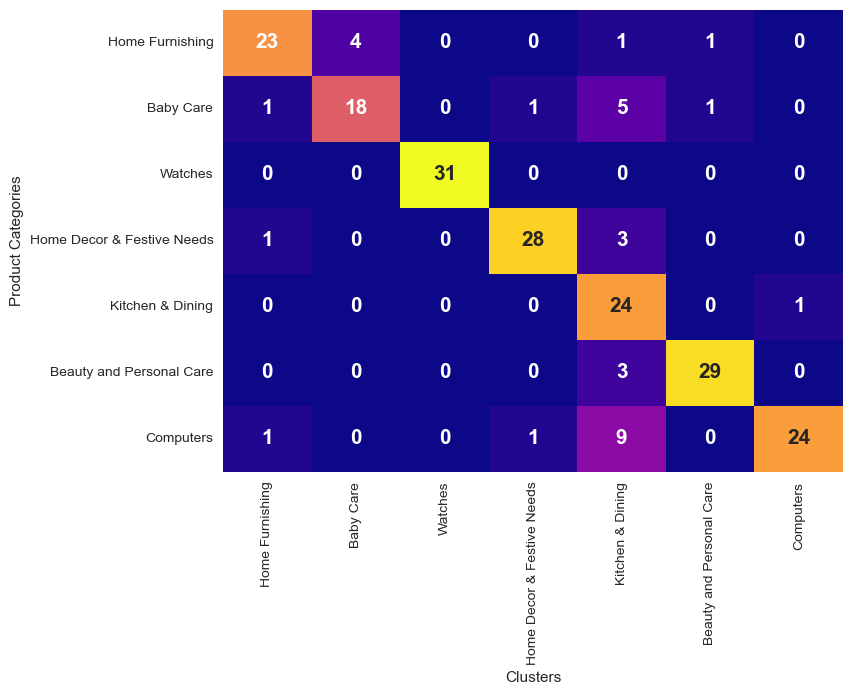

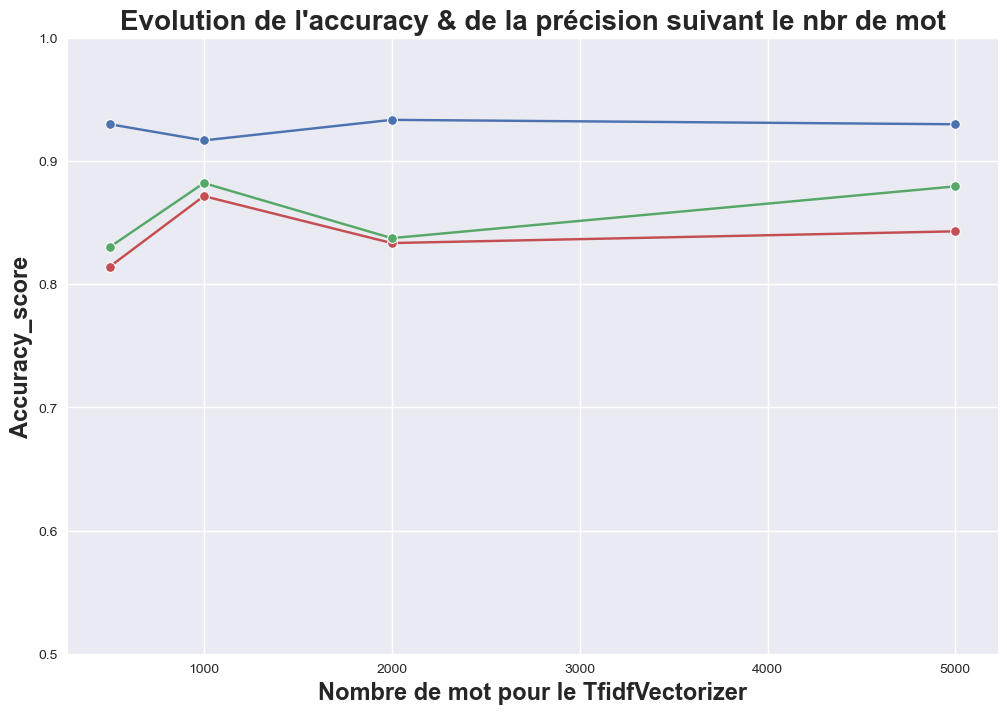

RandomForestClassifier
RandomForestClassifier(max_depth=5, n_estimators=500)
0.8357142857142857
0.8428571428571429
[0.8871499708868129, 0.8853680659255573, 0.8676379271161055, 0.8843854427985757, 0.8301887070617722, 0.8820244129297317, 0.8373156623442666, 0.8793431299882914, 0.8806758832565283]
le nombre des features est 500
RandomForestClassifier(max_depth=5, n_estimators=300)
0.825
0.7714285714285715
[0.8871499708868129, 0.8853680659255573, 0.8676379271161055, 0.8843854427985757, 0.8301887070617722, 0.8820244129297317, 0.8373156623442666, 0.8793431299882914, 0.8806758832565283, 0.8218989652322987]
le nombre des features est 1000
RandomForestClassifier(max_depth=5, n_estimators=500)
0.8369047619047619
0.8428571428571429
[0.8871499708868129, 0.8853680659255573, 0.8676379271161055, 0.8843854427985757, 0.8301887070617722, 0.8820244129297317, 0.8373156623442666, 0.8793431299882914, 0.8806758832565283, 0.8218989652322987, 0.8734206548116322]
le nombre des features est 2000
RandomForestClas

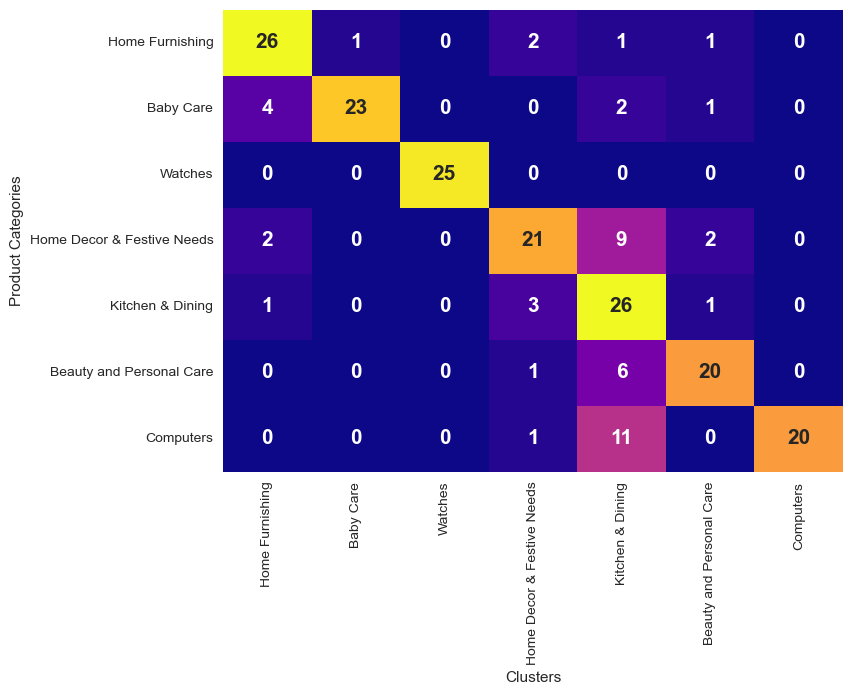

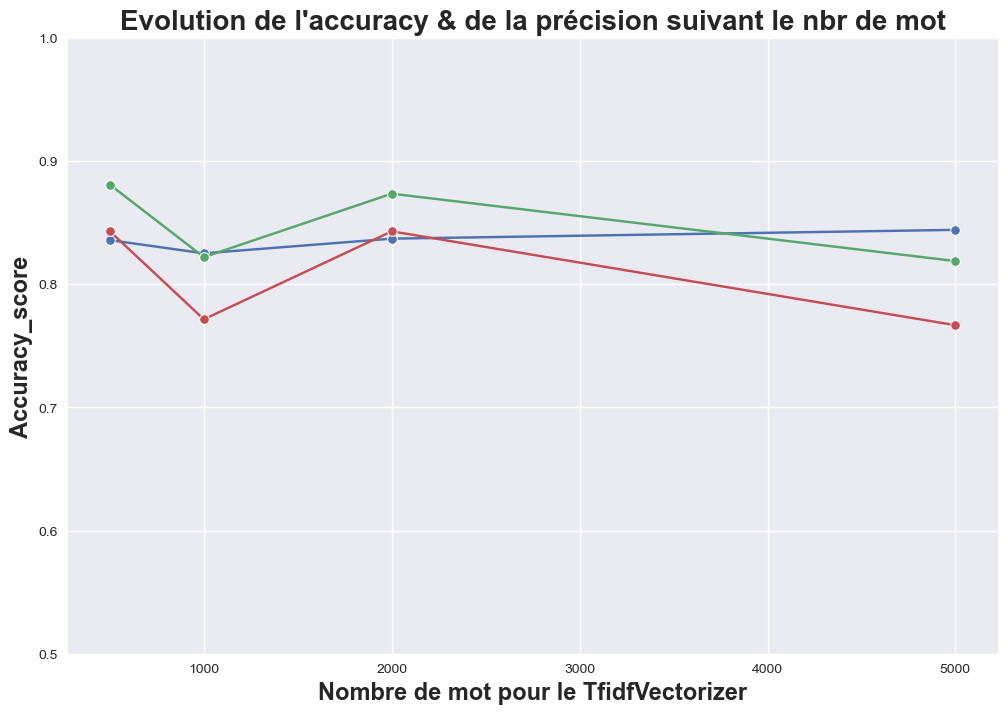

In [35]:
affiche_score(TfidfVectorizer)

#### Affichage du score pour Bag of word

Bag-of-words :
Le bag-of-words consiste à créer une colonne pour chaque mot différent présent pour l'ensemble des textes et d'indiquer le nombre de fois qu'il apparait dans chaque texte. L'histogramme associé consiste à indiquer la fréquence normalisé de l'apparition de chacun des mots dans chaque texte pour l'ensemble du corpus de textes.

In [ ]:
affiche_score(CountVectorizer)

df_compare

In [415]:
df_compare

,product_category,prediction
0,Beauty and Personal Care,Home Decor & Festive Needs
1,Baby Care,Home Decor & Festive Needs
2,Baby Care,Baby Care
3,Home Decor & Festive Needs,Home Decor & Festive Needs
4,Home Furnishing,Home Furnishing
...,...,...
205,Baby Care,Home Decor & Festive Needs
206,Home Furnishing,Home Furnishing
207,Beauty and Personal Care,Home Decor & Festive Needs
208,Home Decor & Festive Needs,Home Decor & Festive Needs


In [297]:
df_real_label_ytest.reset_index(inplace = True, drop = True)
df_compare = pd.concat([df_real_label_ytest, df_prediction], axis=1)
df_compare.columns = ['product_category', 'prediction']

In [72]:
categ_unique_accuracy

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

# Matrice de confusion

In [120]:
from sklearn.decomposition import NMF, LatentDirichletAllocation
nmf = NMF(n_components = data['categ0'].nunique(),
         random_state=1,
         alpha=0.1,
         l1_ratio=0.5).fit(description_matrix)

In [121]:
def print_top_words(nmf, feature_names, n_top_words):
    for topic_idx, topic in enumerate(nmf.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [122]:
tfidf_feature_names = tfidf.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words = 10)

Topic #0: com flipkart genuine shipping cash delivery products buy free guarantee
Topic #1: rockmantra mug ceramic thrilling porcelain permanent crafting stays ensuring start
Topic #2: baby girl details fabric cotton dress boy neck sleeve shirt
Topic #3: watch analog men women discounts india great dial maxima strap
Topic #4: cm showpiece best prices online polyester design inch width 30
Topic #5: mug coffee ceramic mugs tea perfect printland prithish presented wardrobe
Topic #6: laptop skin shapes mouse print warranty pad inches multicolor battery



In [ ]:
affiche_score(CountVectorizer)

df_word2vec = pd.concat(, df[target]], axis=1)

SVC
SVC(C=1.1)
0.8988095238095238
0.819047619047619
[0.8698084556370577, 0.8724936555818908, 0.8730724381378189, 0.8733731627849275, 0.8721637749223955, 0.8759370648844333, 0.8713888888888889, 0.8329181190994916, 0.8342290249433106, 0.7999709519979065, 0.8230563944579443, 0.841247705882799, 0.8517813601146934, 0.8166878556650391, 0.8637491163806954, 0.8229265554460268, 0.8453824073178913]
le nombre des features est 500
SVC(C=1)
0.8928571428571429
0.7952380952380952
[0.8698084556370577, 0.8724936555818908, 0.8730724381378189, 0.8733731627849275, 0.8721637749223955, 0.8759370648844333, 0.8713888888888889, 0.8329181190994916, 0.8342290249433106, 0.7999709519979065, 0.8230563944579443, 0.841247705882799, 0.8517813601146934, 0.8166878556650391, 0.8637491163806954, 0.8229265554460268, 0.8453824073178913, 0.8162470317280517]
le nombre des features est 1000
SVC(C=1.1)
0.9083333333333333
0.8
[0.8698084556370577, 0.8724936555818908, 0.8730724381378189, 0.8733731627849275, 0.8721637749223955, 0.8

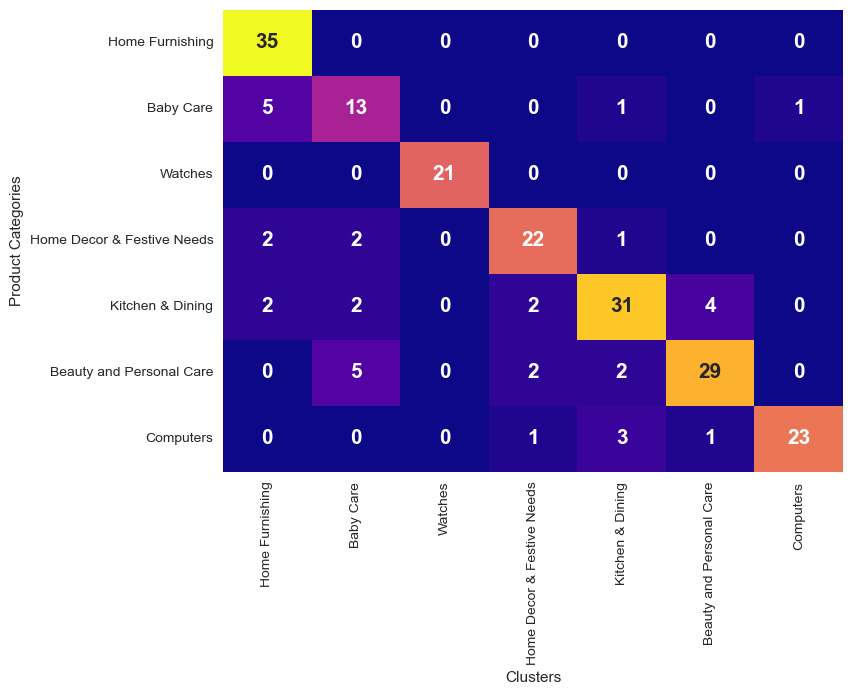

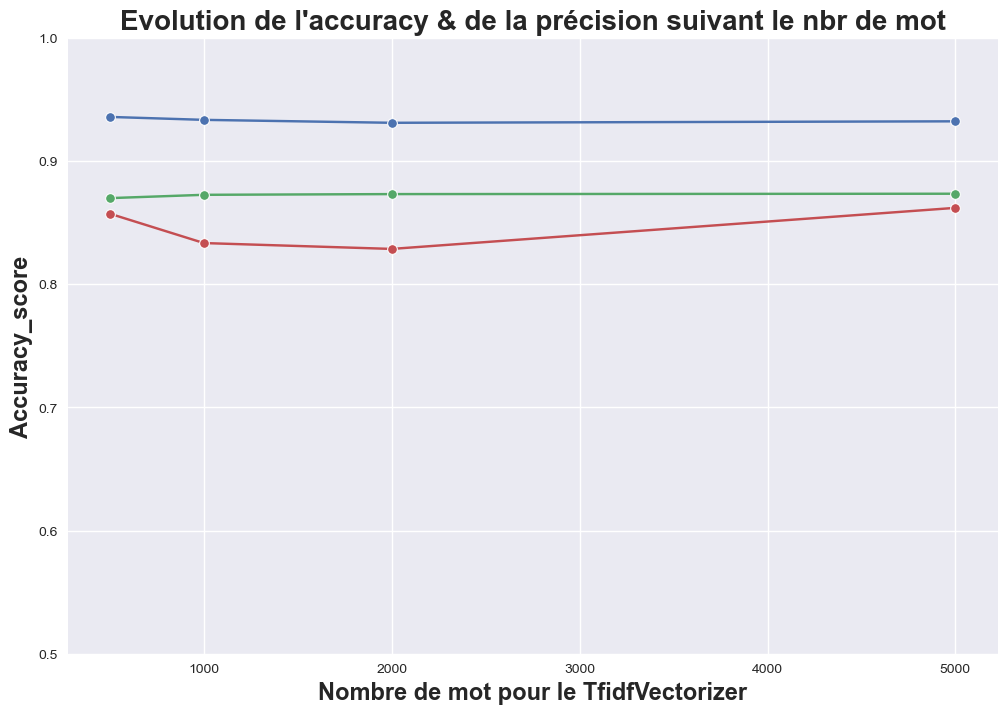

LogisticRegression
LogisticRegression(C=0.1)
0.9154761904761904
0.8285714285714286
[0.8698084556370577, 0.8724936555818908, 0.8730724381378189, 0.8733731627849275, 0.8721637749223955, 0.8759370648844333, 0.8713888888888889, 0.8329181190994916, 0.8342290249433106, 0.7999709519979065, 0.8230563944579443, 0.841247705882799, 0.8517813601146934, 0.8166878556650391, 0.8637491163806954, 0.8229265554460268, 0.8453824073178913, 0.8162470317280517, 0.8407144567443571, 0.8350074160445677, 0.86752246190874]
le nombre des features est 500
LogisticRegression(C=0.5)
0.9321428571428572
0.8333333333333334
[0.8698084556370577, 0.8724936555818908, 0.8730724381378189, 0.8733731627849275, 0.8721637749223955, 0.8759370648844333, 0.8713888888888889, 0.8329181190994916, 0.8342290249433106, 0.7999709519979065, 0.8230563944579443, 0.841247705882799, 0.8517813601146934, 0.8166878556650391, 0.8637491163806954, 0.8229265554460268, 0.8453824073178913, 0.8162470317280517, 0.8407144567443571, 0.8350074160445677, 0.86

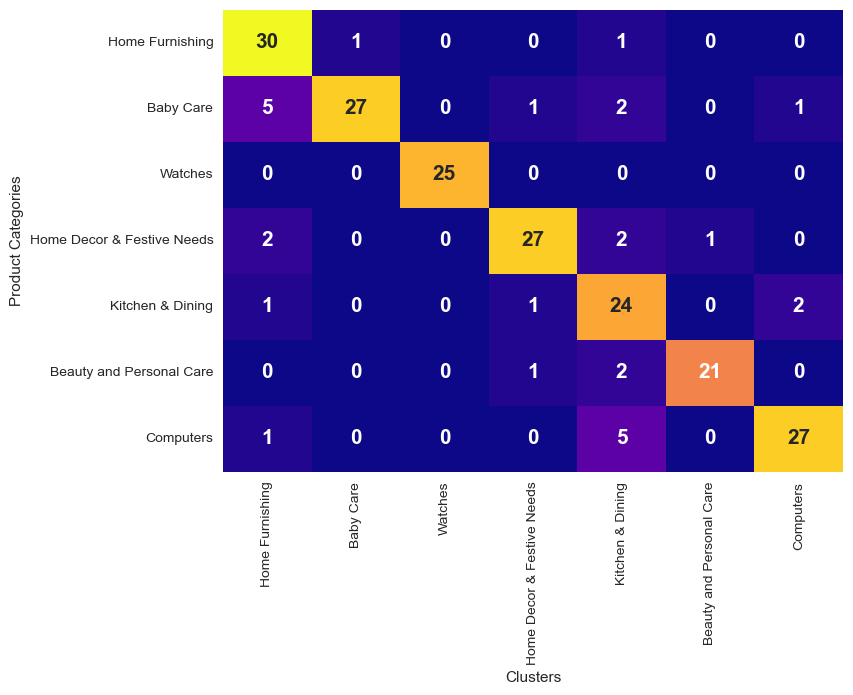

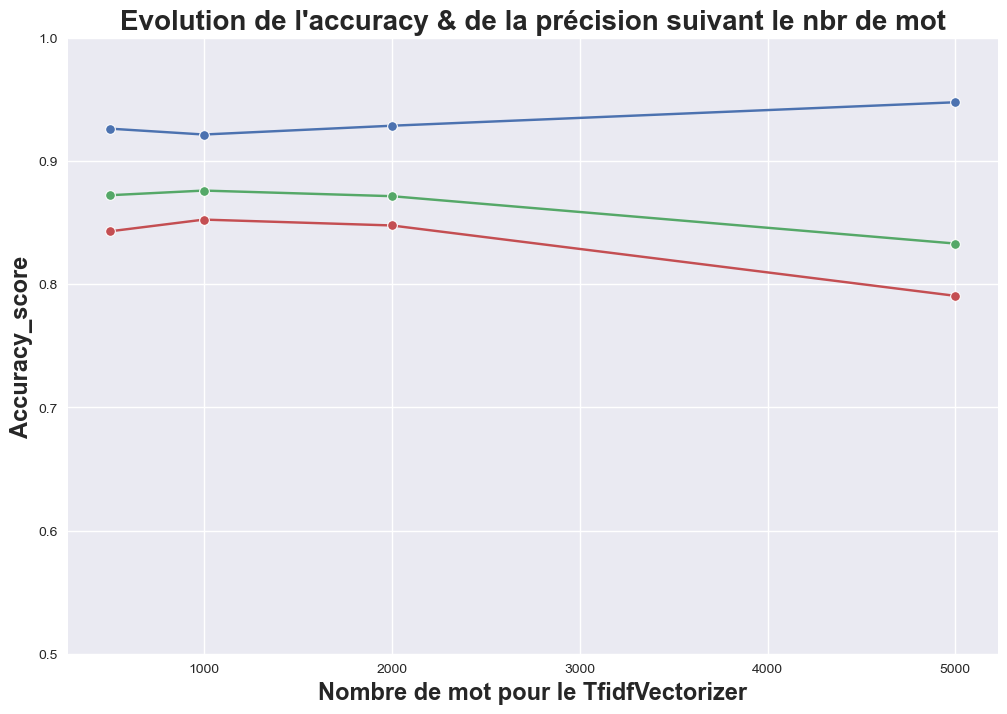

RandomForestClassifier
RandomForestClassifier(max_depth=5, n_estimators=500)
0.8273809523809523
0.7666666666666667
[0.8698084556370577, 0.8724936555818908, 0.8730724381378189, 0.8733731627849275, 0.8721637749223955, 0.8759370648844333, 0.8713888888888889, 0.8329181190994916, 0.8342290249433106, 0.7999709519979065, 0.8230563944579443, 0.841247705882799, 0.8517813601146934, 0.8166878556650391, 0.8637491163806954, 0.8229265554460268, 0.8453824073178913, 0.8162470317280517, 0.8407144567443571, 0.8350074160445677, 0.86752246190874, 0.8421418467324391, 0.8268720015938672, 0.8781210852639424, 0.8180418072598524]
le nombre des features est 500
RandomForestClassifier(max_depth=5, n_estimators=500)
0.8178571428571428
0.7714285714285715
[0.8698084556370577, 0.8724936555818908, 0.8730724381378189, 0.8733731627849275, 0.8721637749223955, 0.8759370648844333, 0.8713888888888889, 0.8329181190994916, 0.8342290249433106, 0.7999709519979065, 0.8230563944579443, 0.841247705882799, 0.8517813601146934, 0.81

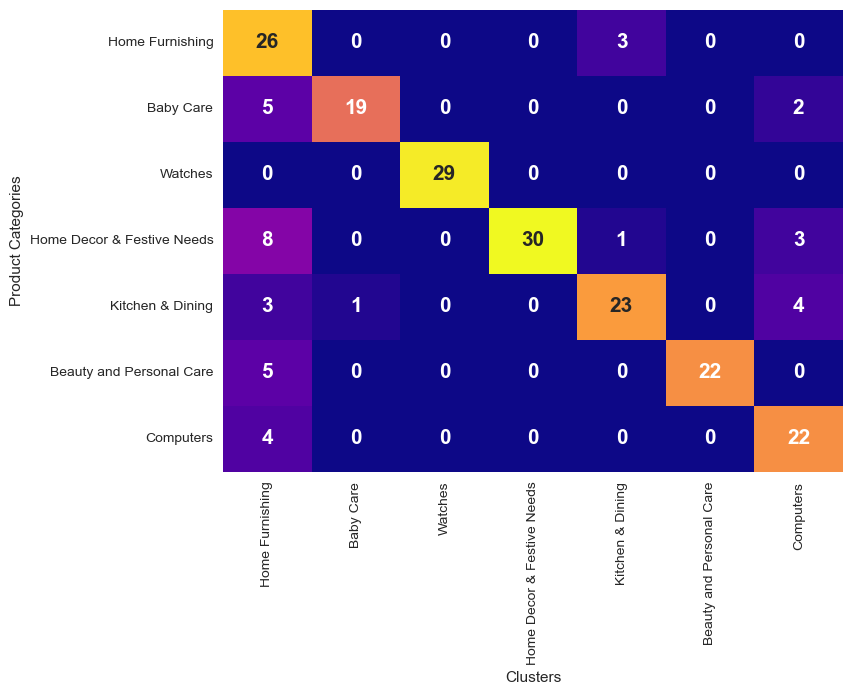

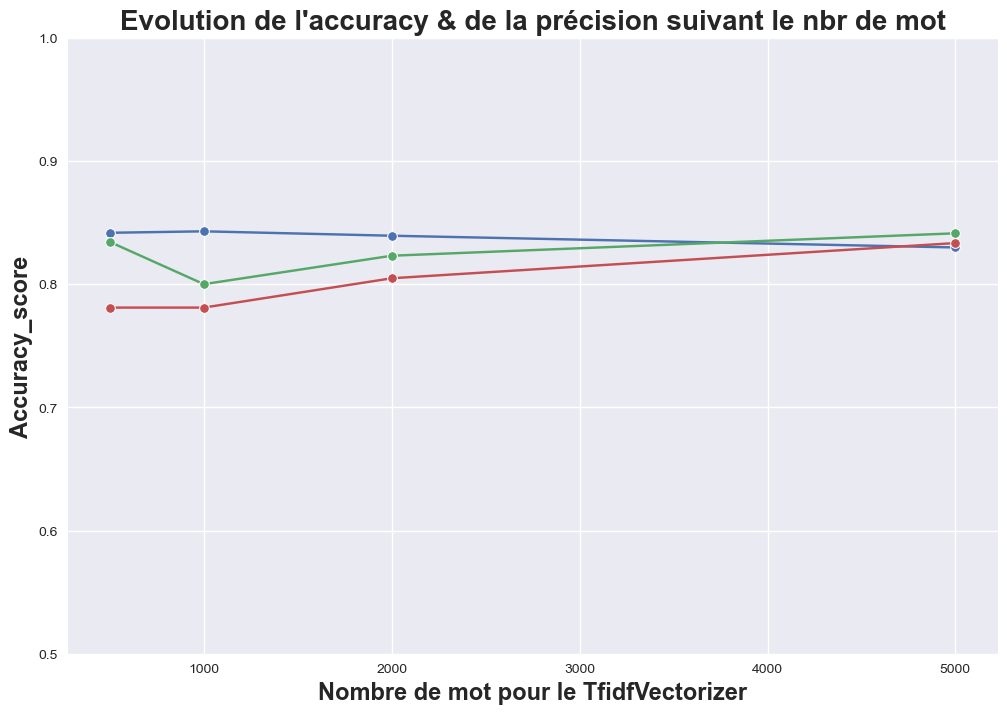

In [34]:
vectoriser = CountVectorizer(max_df=0.9,
                                      min_df=0.05,
                                      max_features=i, 
                                      stop_words='english',
                                      lowercase=True)
affiche_score(CountVectorizer)

In [1]:
#test_score

In [2]:
#df2.iloc[:,:df2.shape[1] - 1]

## Vectorisation word2Vec

Word2vec est un groupe de modèles utilisé pour le plongement lexical (word embedding). Ces modèles ont été développés par une équipe de recherche chez Google sous la direction de Tomas Mikolov. Ce sont des réseaux de neurones artificiels à deux couches entraînés pour reconstruire le contexte linguistique des mots. La méthode est implémentée dans la bibliothèque Python Gensim.

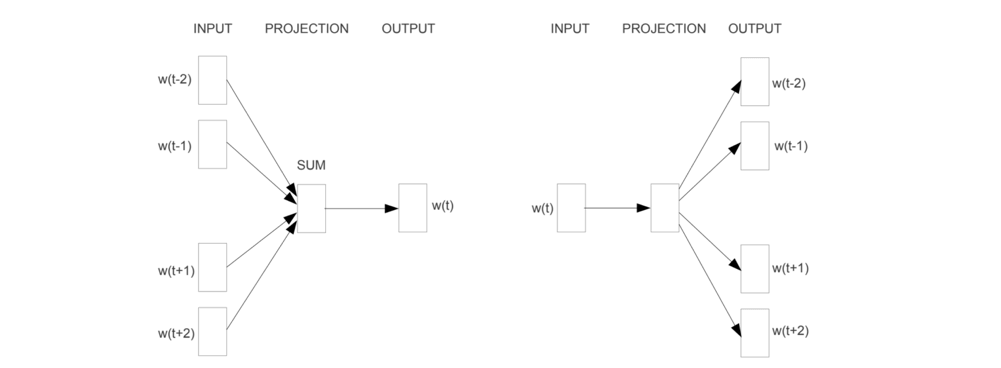

In [180]:
from IPython.display import display, Image
path = '/Users/admin/Desktop/Word2Vec.png'
display(Image(path, filename=path))

#### Nettoyage des données

In [73]:
text = df['description'].iloc[1]
print(text)
#split into words
from nltk.tokenize import word_tokenize
tokens = word_tokenize(text)
# convert to lower case
tokens = map(str.lower, tokens)
#print('-----Tokenizer--------')
#print(list(tokens))
# remove punctuation from each word
import string
table = str.maketrans('', '', string.punctuation)
stripped = [w.translate(table) for w in tokens]
# remove remaining tokens that are not alphabetic
words = [word for word in stripped if word.isalpha()]
# filter out stop words
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
words = [w for w in words if w not in stop_words]
#print('----------stop_words----------')
#print(words)
# stemming of words
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
words = [porter.stem(word) for word in words]
print('----------Stemmer----------')
print(words)

Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel
----------Stemmer----------
['specif', 'sathiya', 'cotton', 'bath', 'towel', 'bath', 'towel', 'red', 'yellow', 'blue', 'bath', 'towel', 'featur', 'machin', 'washabl', 'ye', 'materi', 'cotton', 'design', 'self', 'design', 'gener', 'brand', 'sathiya', 'type', 'bath', 'towel', 'gsm', 'model', 'name', 'sathiya', 'cotton', 'bath', 'towel', 'ideal', 'men', 'women', 'boy', 'girl', 'model', 'id', 'color', 'red', 'yellow', 'blue', 'size', 'mediam', 'dimens', 'length', 'inch', 'width', 'inch', 'box', 'number', 'content', 'sale', 'packag', 'sale', 'packag', 'b

In [74]:
def nettoyage_document(text, stemmed=False, output='tokens'):
    """
    - text : string (document) à nettoyer.
    - output : string ('tokens' pour avoir des tokens en output, sinon l'output est un string des tokens concaténés)
    Returns :
    - texte nettoyé (sous forme de liste de strings (output='tokens'), ou de string reconcaténé)
    """
    # split into words
    from nltk.tokenize import word_tokenize
    tokens = word_tokenize(text)
    # convert to lower case
    tokens = map(str.lower, tokens)
    # remove punctuation from each word
    import string
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if w not in stop_words]
    # stemming of words
    if stemmed:
        from nltk.stem.porter import PorterStemmer
        porter = PorterStemmer()
        words = [porter.stem(word) for word in words]

    # return
    if output == 'tokens':
        return words
    else:
        return ' '.join(words)

In [75]:
descriptions_w2v = df['description'].copy().map(
    lambda texte: nettoyage_document(texte, stemmed=False, output='T'))

In [76]:
descriptions_w2v

0       key features elegance polyester multicolor abs...
1       specifications sathiyas cotton bath towel bath...
2       key features eurospa cotton terry face towel s...
3       key features santosh royal fashion cotton prin...
4       key features jaipur print cotton floral king s...
                              ...                        
1045    oren empower extra large self adhesive sticker...
1046    wallmantra large vinyl sticker sticker pack pr...
1047    buy uberlyfe extra large pigmented polyvinyl f...
1048    buy wallmantra medium vinyl sticker sticker on...
1049    buy uberlyfe large vinyl sticker online uberly...
Name: description, Length: 1050, dtype: object

In [90]:
#nettoyage_document(df['description'].iloc[1], output='tokens')

In [77]:
import spacy
spacy.load('en_core_web_sm')
from spacy.lang.en import English

In [127]:
spacy.load("en_core_web_sm")

In [78]:
try:
    import spacy
    nlp = spacy.load('en_core_web_sm')
except Exception as e:
    # Un message d'erreur peut apparaître.
    # cymem.cymem.Pool has the wrong size, try recompiling. Expected 64, got 48
    # Sous Windows:
    # pip install http://www.xavierdupre.fr/enseignement/setup/cymem-1.31.2-cp37-cp37m-win_amd64.whl
    # pip install http://www.xavierdupre.fr/enseignement/setup/thinc-6.10.2-cp37-cp37m-win_amd64.whl
    # pip install http://www.xavierdupre.fr/enseignement/setup/spacy-2.0.12-cp37-cp37m-win_amd64.whl
    print(e)

In [79]:
stopwords = stopwords.words('english')

In [80]:
sentences = df['description'].copy().map(
    lambda texte: nettoyage_document(texte, stemmed=True, output='sentences'))
words = df['description'].copy().map(
    lambda texte: nettoyage_document(texte, stemmed=False, output='tokens'))

In [81]:

text_dim = 1000
print("Training Word2Vec model...")
wordvec_model = Word2Vec(words, vector_size=1000,  window=5, min_count=3, workers=4, sg=1)
print(type(wordvec_model))
dir(wordvec_model)
print("%d unique words represented by %d dimensional vectors" % (len(wordvec_model.wv.index_to_key), text_dim))
print(wordvec_model.wv.most_similar(positive=['elegance']))
print(wordvec_model.wv.most_similar(positive=['pizza']))

Training Word2Vec model...
<class 'gensim.models.word2vec.Word2Vec'>
2301 unique words represented by 1000 dimensional vectors
[('jack', 0.9891653656959534), ('north', 0.9834128618240356), ('escort', 0.9790629744529724), ('calibro', 0.9767867922782898), ('functions', 0.9762282371520996), ('fibre', 0.9759963750839233), ('floats', 0.9748699069023132), ('digiprint', 0.9747670888900757), ('stiched', 0.9733158349990845), ('formula', 0.9728017449378967)]
[('cutter', 0.9820659756660461), ('grip', 0.9161357879638672), ('sharp', 0.8871135711669922), ('beautifully', 0.8815633058547974), ('crafted', 0.881331741809845), ('deliver', 0.8797351121902466), ('blade', 0.8778515458106995), ('gifts', 0.8762848377227783), ('indian', 0.875391960144043), ('rolling', 0.873345136642456)]


In [82]:
wordvec_model.wv.index_to_key

['products',
 'free',
 'rs',
 'buy',
 'delivery',
 'shipping',
 'cash',
 'genuine',
 'replacement',
 'cm',
 'day',
 'flipkartcom',
 'guarantee',
 'online',
 'features',
 'specifications',
 'price',
 'watch',
 'mug',
 'baby',
 'color',
 'pack',
 'material',
 'set',
 'type',
 'cotton',
 'box',
 'general',
 'package',
 'sales',
 'analog',
 'warranty',
 'number',
 'quality',
 'details',
 'product',
 'brand',
 'best',
 'design',
 'model',
 'ceramic',
 'key',
 'laptop',
 'fabric',
 'prices',
 'showpiece',
 'great',
 'made',
 'perfect',
 'india',
 'men',
 'usb',
 'size',
 'inch',
 'multicolor',
 'girl',
 'dimensions',
 'ideal',
 'home',
 'skin',
 'contents',
 'combo',
 'water',
 'gift',
 'women',
 'x',
 'printed',
 'discounts',
 'mugs',
 'width',
 'black',
 'wash',
 'also',
 'print',
 'care',
 'battery',
 'ml',
 'power',
 'cover',
 'light',
 'adapter',
 'coffee',
 'yes',
 'height',
 'blue',
 'pattern',
 'use',
 'style',
 'high',
 'length',
 'dress',
 'name',
 'easy',
 'weight',
 'one',
 'roun

In [145]:
print('Cleaned up training data size (i.e. number of sentences): ', len(descriptions_w2v))

Cleaned up training data size (i.e. number of sentences):  1050


In [83]:
count = 0
for i in range(len(words)):
    if words[i] == "":
        print("index:", i)
        count += 1
print(count)

0


In [84]:
def create_average_vec(doc):
    nomb_word_vec = 1000
    average = np.zeros((nomb_word_vec,), dtype='float32')
    num_words = 0.
    
    for word in doc.split():
        if word in wordvec_model.wv.index_to_key:
            average = np.add(average, wordvec_model.wv[word])
            num_words += 1.
            
    if num_words != 0.:
        average = np.divide(average, num_words)
        
    return average

In [85]:
def average_feature_vec(doc, nomb_word_vec = 1000):
    import warnings

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", DeprecationWarning)

        descFeatureVecs = np.zeros((df.shape[0], nomb_word_vec), dtype="float32")  # 1050 x 1000
    
        for i in range(len(descriptions_w2v)):
            descFeatureVecs[i] = create_average_vec(doc[i])
        df_descFeatureVecs = pd.DataFrame(descFeatureVecs)

    print("Train word vector shape:", descFeatureVecs.shape)
    return df_descFeatureVecs
average_feature_vec = average_feature_vec(sentences, nomb_word_vec =1000)

Train word vector shape: (1050, 1000)


In [86]:
average_feature_vec

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.010569,0.031906,0.013102,0.064579,-0.029694,0.086132,0.019601,0.044362,-0.022206,0.015511,...,0.073659,-0.079562,0.075783,-0.022526,0.015915,0.023705,0.021262,-0.084369,-0.054250,-0.062787
1,0.009528,0.063987,0.032833,0.100766,-0.023995,0.041050,0.050886,0.026496,-0.076333,0.042813,...,0.049321,-0.109289,0.053018,-0.042207,0.040162,0.035320,-0.008053,-0.078165,-0.051323,-0.112602
2,-0.004210,0.040577,0.029275,0.063702,-0.020403,0.037730,0.021543,0.031892,-0.040433,0.053191,...,0.058397,-0.108967,0.066593,-0.015220,0.032677,0.019291,0.013800,-0.076489,-0.048546,-0.099930
3,-0.012279,0.059524,0.003292,0.044948,-0.063710,0.089824,0.061244,0.051063,-0.030869,0.106771,...,0.042903,-0.119188,0.094405,-0.020846,0.006064,-0.007552,0.025225,-0.102397,-0.044792,-0.082397
4,-0.008731,0.041618,0.007326,0.041701,-0.046691,0.091712,0.047831,0.053219,-0.023968,0.093750,...,0.055887,-0.115183,0.093359,-0.010122,0.005100,-0.003672,0.030254,-0.093253,-0.046431,-0.071117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0.005029,0.007164,0.020379,0.033866,-0.006145,0.040198,-0.027073,0.033583,-0.016166,-0.000839,...,0.069768,-0.071279,0.065554,-0.011739,0.024209,0.002152,0.016231,-0.061235,-0.052413,-0.062353
1046,0.004881,0.008091,0.020114,0.024957,-0.004904,0.062225,-0.022929,0.053003,0.001757,0.022409,...,0.087972,-0.089012,0.092190,0.006703,0.001765,-0.011846,0.033656,-0.078483,-0.058334,-0.041343
1047,0.031500,-0.011404,0.072313,0.102948,-0.016366,0.069649,-0.070521,0.056995,-0.066569,-0.004926,...,0.104712,-0.067693,0.081489,-0.031410,0.025531,0.006225,-0.024328,-0.086593,-0.044570,-0.032050
1048,0.016835,-0.008557,0.054976,0.085085,-0.022042,0.074889,-0.059657,0.060523,-0.049997,0.004403,...,0.091053,-0.066524,0.082838,-0.027222,0.028753,0.004639,-0.009313,-0.085567,-0.045597,-0.030323


In [87]:
df_word2ec = pd.concat([df['categ0'], average_feature_vec] , axis=1)
X_train_w2v, X_test_w2v, Y_train_w2v, Y_test_w2v = train_test_split(df_word2ec.drop('categ0', axis = 1), 
                                                    df_word2ec['categ0'], 
                                                test_size=0.2)

In [88]:
params_SVC = {'C' : [0.01, 0.1, 0.5, 0.9, 1, 1.1]}
params_Rforest ={'max_depth': range(3,6),'n_estimators': (200,300,500)}

In [89]:
models = {'RandomForestClassifier': RandomForestClassifier(),'SVC' :SVC()}

accuracy sur jeu train :  0.8380952380952381
accuracy sur jeu train :  0.8428571428571429


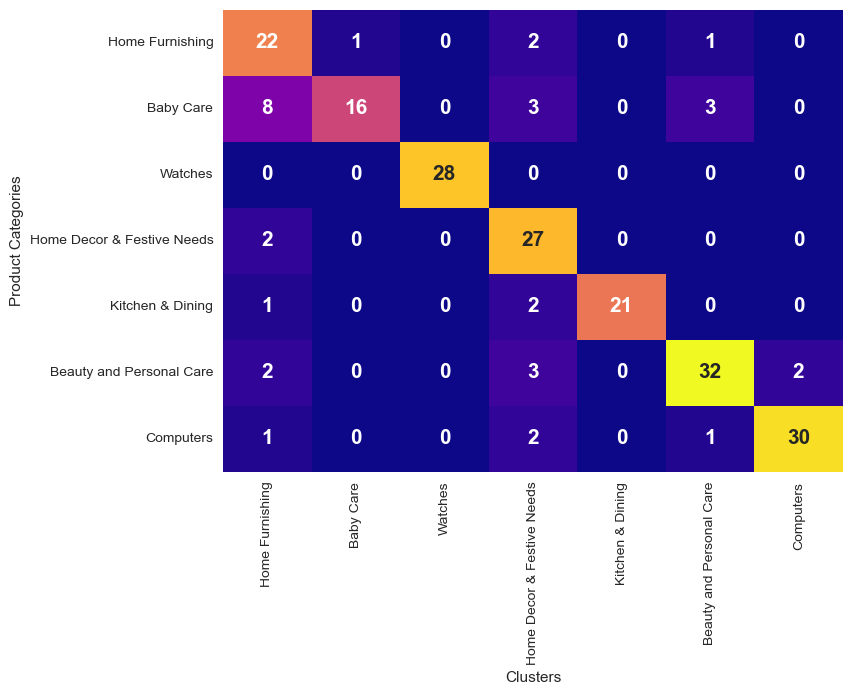

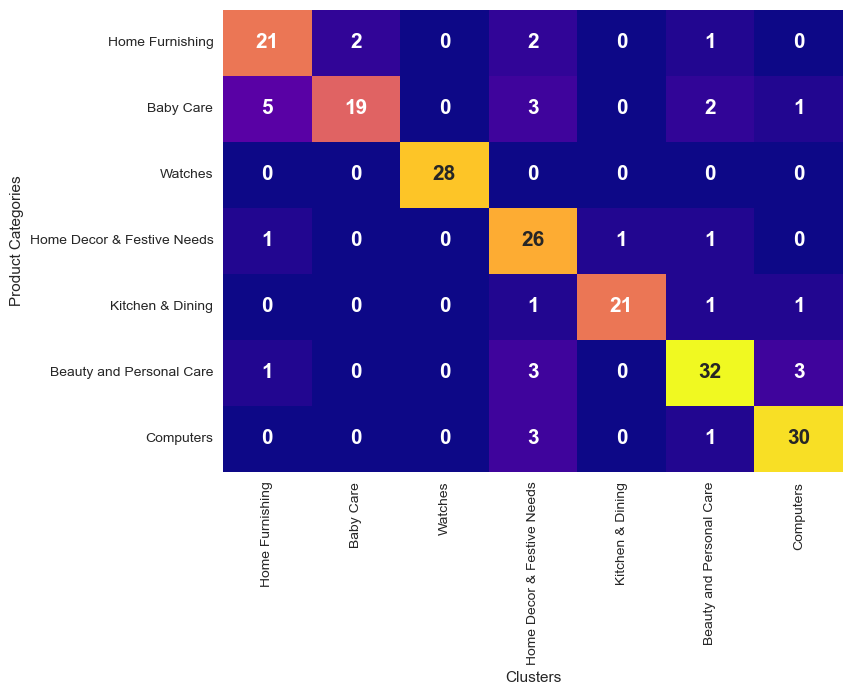

In [90]:
for name_models, model in models.items():
    if name_models == 'RandomForestClassifier':
        params = params_Rforest
    else:
        params = params_SVC
    gridsearch = GridSearchCV(model, param_grid = params, cv=8)
    gridsearch.fit(X_train_w2v, Y_train_w2v)
    y_pred = gridsearch.best_estimator_.predict(X_test_w2v)
    x_pred = gridsearch.best_estimator_.predict(X_train_w2v)
    print('accuracy sur jeu train : ', accuracy_score(Y_test_w2v, y_pred))
    if model == SVC():
        print('accuracy sur jeu train : ', accuracy_score(model.best_estimator_.predict(X_train_w2v), Y_train_w2v))
#print('accuracy sur jeu test : ', 
     # accuracy_score(svc.best_estimator_.predict(
        # (stem_vectorizer.transform(X_train, Y_train)))))
    df_y_predict = pd.DataFrame(y_pred)
    df_Y_test_w2v = pd.DataFrame(Y_test_w2v)
    df_Y_test_w2v.reset_index(inplace = True, drop = True)
    df_compare = pd.concat([df_Y_test_w2v, df_y_predict], axis=1)
    df_compare.columns = ['product_category', 'prediction']
    list_categ = df['categ0'].unique()
    mat_conf = confusion_matrix(df_compare['product_category'], df_compare['prediction'], labels = list_categ)
# Mise sous forme de DataFrame
    mat_conf_df = pd.DataFrame(mat_conf,  index=list_categ, columns=list_categ)
    plt.figure(figsize=(8,6))
    sns.heatmap(mat_conf_df,
    xticklabels=True, 
    yticklabels= True, 
    annot=True,
    cmap="plasma", cbar=False,
    annot_kws={"size": 15, 'weight' : 'bold'})
#sns.heatmap(mat_conf_df, annot=True, linewidths=.3)
    plt.ylabel('Product Categories')
    plt.xlabel('Clusters')
    
    

## Classifieurs non supervisé

#### ACP, Kmeans, Score_ARI et TSNE

In [92]:
def ACP(X):
    #print('Variance expliquée')
    #X_train, X_test, Y_train, Y_test = train_test_split(df_des_target .drop(target, axis = 1), 
                                                  #  df_des_target[target], 
    X_reduce = []                                            #test_size=0.2)
    #X = pd.concat([X_train, X_test])
    pca = PCA(random_state=0)
    pca.fit(X)
    sum_pca = np.cumsum(pca.explained_variance_ratio_)
    #X_reduit = pca.transform(X[:14,:])
    #X_reduce = pca.transform(X)[:,:counter]
    ratio_lambda = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(10,4))
    plt.title('Somme cumulée de variance des composantes de l\'ACP')
    plt.xlabel('Nombre de composantes de l\'ACP')
    plt.ylabel('Variance cumulée')
    plt.plot(list(range(X.shape[1])), ratio_lambda)

#variance expliquée
    ratio_lambda = np.cumsum(pca.explained_variance_ratio_)

#Affichage du nombre de variable à garder , ie ont une varince cumulés inférieur à .9
    liste_X = []
    liste_Y = []
    ymax = 0.9
    for i, j in zip(list(range(X.shape[1])), ratio_lambda):
        if j >= ymax:
            liste_X.append(i)
            liste_Y.append(j)
    print('le nombre de variable à conserver est:', liste_X[0])

#Point sur la courbe de variance cumulés qui sépare le nombre de vaibale à garder de celles à supprimer 
    plt.plot(liste_X[0],liste_Y[0], marker="o", color="red")
    plt.axvline(x = liste_X[0], ymax=liste_Y[0], color = 'r', ls='--')
    plt.axhline(y = liste_Y[0], xmax = liste_X[0], color = 'r', ls='--')
    plt.show()

#ACP(X)


In [109]:
df['categ0'].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [36]:
from sklearn.metrics import silhouette_score, adjusted_rand_score, silhouette_samples

word2ec
le nombre de variable à conserver est: 4


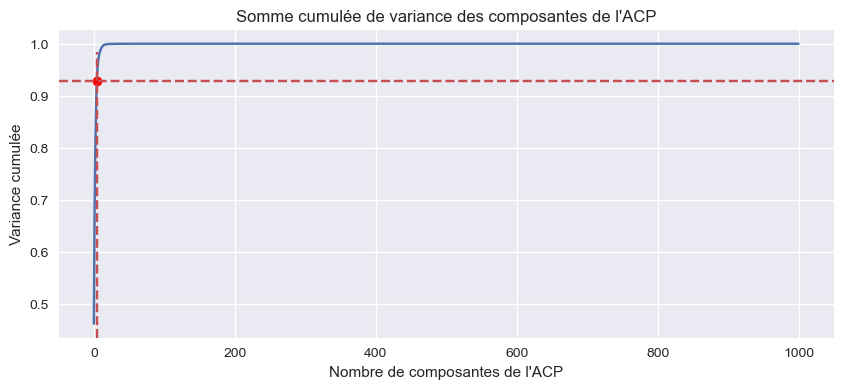

Labels_KM
0     95
1    144
2     45
3    212
4    126
5    217
6    211
dtype: int64
Score_ARI=: 0.2684386995120251
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.022s...
[t-SNE] Computed neighbors for 1050 samples in 0.140s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.234950
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.745720
[t-SNE] KL divergence after 300 iterations: 0.431200
TSNE terminée. Temps écoulé 2.165757179260254 seconds.
vectoriser_tf
le nombre de variable à conserver est: 46


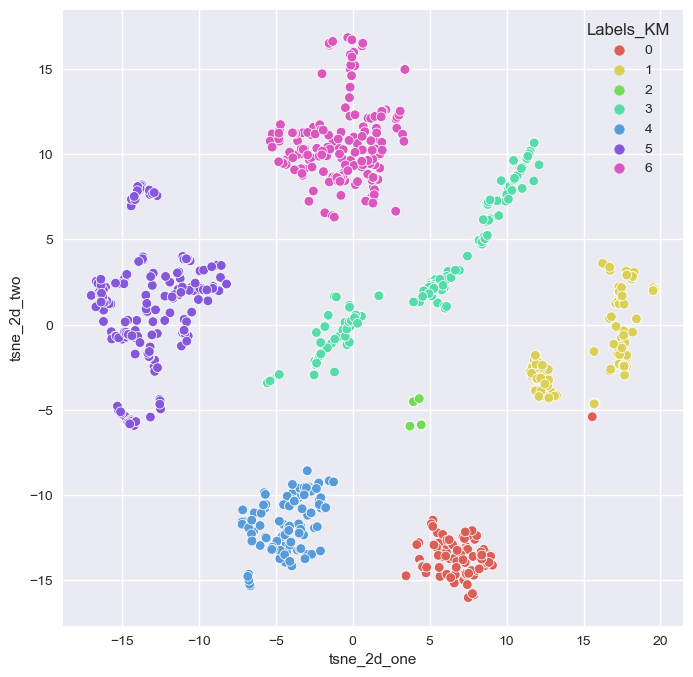

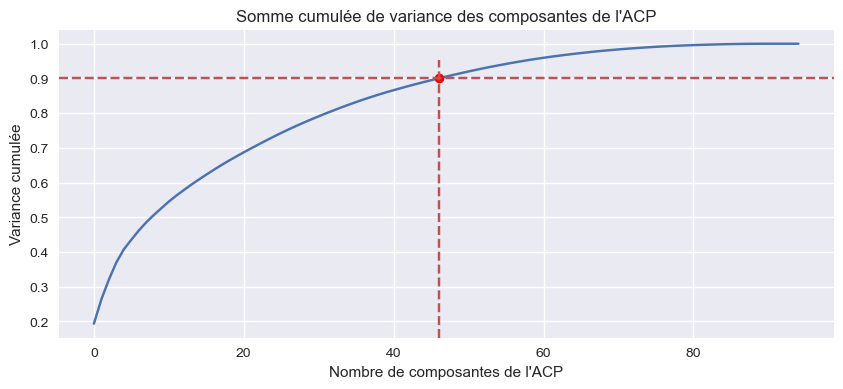

Labels_KM
0     75
1    140
2    245
3    258
4    185
5     85
6     62
dtype: int64
Score_ARI=: 0.20957327995197056
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples in 0.048s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.535446
[t-SNE] KL divergence after 300 iterations: 0.604347
TSNE terminée. Temps écoulé 2.929409980773926 seconds.
X_vectoriser_c
le nombre de variable à conserver est: 44


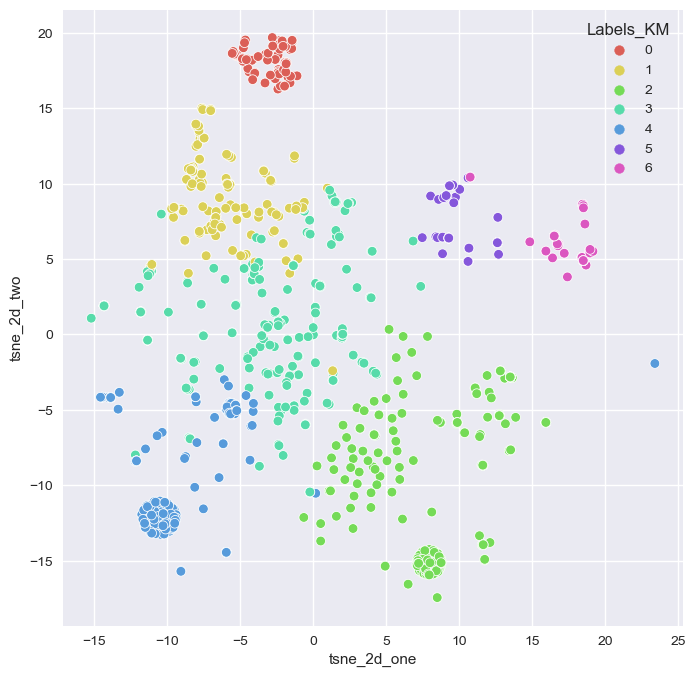

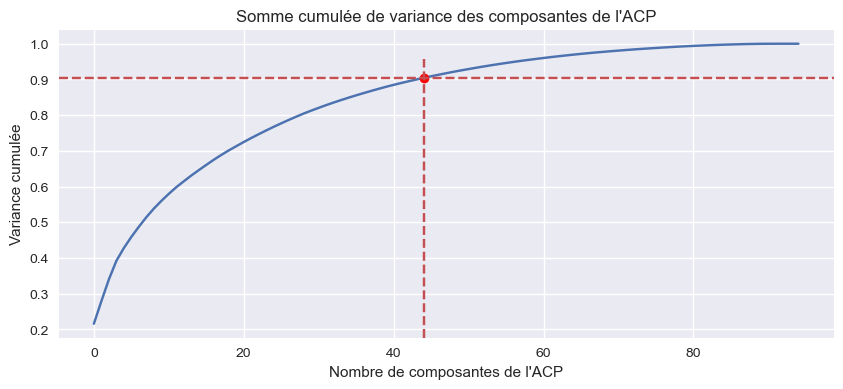

Labels_KM
0     73
1    101
2    431
3     20
4    235
5     54
6    136
dtype: int64
Score_ARI=: 0.18211363259374141
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.000s...
[t-SNE] Computed neighbors for 1050 samples in 0.045s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.037895
[t-SNE] KL divergence after 300 iterations: 0.556188
TSNE terminée. Temps écoulé 2.2510390281677246 seconds.


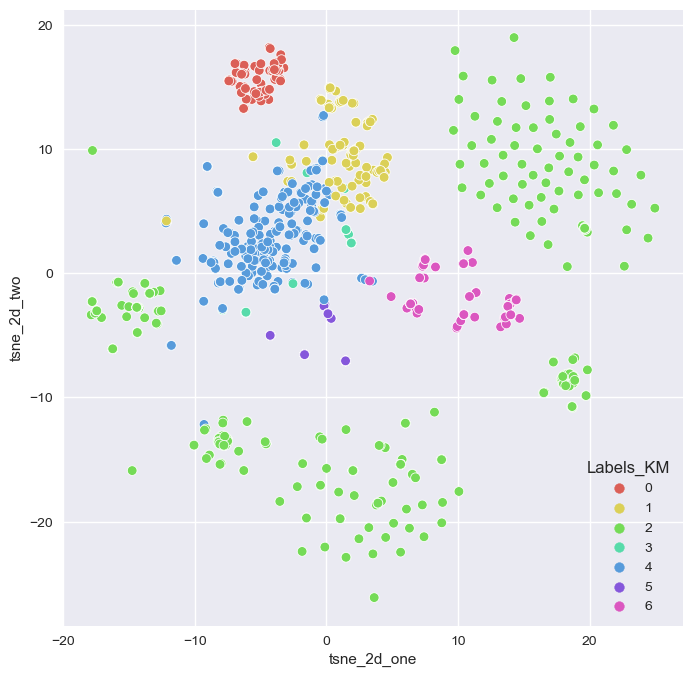

In [178]:
vectoriser_c = CountVectorizer(max_df=0.995,
                                      min_df=0.05, 
                                      stop_words='english',
                                      lowercase=True)
vectoriser_tf = TfidfVectorizer(max_df=0.995,
                                      min_df=0.05, 
                                      stop_words='english',
                                      lowercase=True)
X_train, X_test, Y_train, Y_test, df_description_matrix_standard = process(model = vectoriser_c , df = df, target = 'categ0', var_use_to_pred = 'description')
X_vectoriser_c = df_description_matrix_standard
X_train, X_test, Y_train, Y_test, df_description_matrix_standard = process(model = vectoriser_tf, df = df, target = 'categ0', var_use_to_pred = 'description')
X_vectoriser_tf = df_description_matrix_standard
X_word2ec = df_word2ec.drop('categ0', axis = 1)
X = {'word2ec':X_word2ec, 'vectoriser_tf':X_vectoriser_tf, 'X_vectoriser_c':X_vectoriser_c}
for name_vec, x_vec in X.items():
    print(name_vec)
    ACP(X = x_vec)
    #X_reduce = pca.transform(x_vec)[:,:counter]
    km = KMeans(n_clusters=7, 
            init='k-means++',
            random_state=2)
    y_kmeans = km.fit_predict(X= x_vec)
    X1 = x_vec.copy()
    X1['Labels_KM'] = km.labels_
    #X1['Categ'] = df['categ0']
    print(X1.groupby('Labels_KM').size())
    
    x_vec['Categ'] = df['categ0']
    
    x =  adjusted_rand_score(X1['Labels_KM'], x_vec['Categ'])
    print('Score_ARI=:', x)
    
    #display(x_vec)
    
    time_start= time.time()

    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    
    tsne_results = tsne.fit_transform(X1)
    
    print("TSNE terminée. Temps écoulé {} seconds.".format(time.time() - time_start))

    df_results = pd.DataFrame(tsne_results, columns=["tsne_2d_one", "tsne_2d_two"])
    
    #df_results["labels"] = labels #cls_kmeans.labels_
        
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(
        x=df_results["tsne_2d_one"],
        y=df_results["tsne_2d_two"],
        hue=X1['Labels_KM'],
        palette=sns.color_palette("hls", n_colors = 7),
        data=df_results,
        legend="full"
    )
    
    #print(y_kmeans.tolist())
    
    #tsne = TSNE(n_components=2)
    #T = tsne.fit_transform(X1.drop('Categ', axis = 1).copy())
    #plt.figure(figsize=(8,8))
    #plt.title('Représentation du jeu de données via T-SNE')
    #sns.scatterplot(T[:,0], T[:,1],marker='x',
    #c=y_kmeans)

In [122]:
X_vectoriser_c

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,Categ
0,2.365865,-0.856718,-0.294884,-0.374303,-0.278598,-0.478959,-0.217458,-0.202548,2.032926,1.186352,...,-0.246338,-0.199306,-0.239340,-0.353432,-0.233702,-0.262232,-0.294443,-0.272064,-0.237975,Home Furnishing
1,-0.213739,0.949615,-0.294884,-0.374303,-0.278598,-0.478959,-0.217458,3.342040,-0.209272,1.186352,...,-0.246338,-0.199306,-0.239340,-0.353432,-0.233702,-0.262232,2.047720,1.783093,1.934839,Baby Care
2,4.945468,-0.856718,-0.294884,-0.374303,-0.278598,-0.478959,-0.217458,-0.202548,-0.209272,1.186352,...,1.983449,-0.199306,5.650662,-0.353432,1.447032,2.437219,2.047720,1.783093,-0.237975,Baby Care
3,-0.213739,-0.856718,-0.294884,-0.374303,-0.278598,-0.478959,-0.217458,-0.202548,-0.209272,1.186352,...,-0.246338,-0.199306,1.723994,-0.353432,-0.233702,-0.262232,6.732047,-0.272064,1.934839,Home Furnishing
4,4.945468,-0.856718,-0.294884,-0.374303,-0.278598,-0.478959,-0.217458,-0.202548,-0.209272,1.186352,...,-0.246338,0.637779,-0.239340,-0.353432,-0.233702,2.437219,6.732047,-0.272064,1.934839,Home Furnishing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,-0.213739,-0.856718,-0.294884,-0.374303,-0.278598,-0.478959,-0.217458,-0.202548,-0.209272,-0.457012,...,4.213235,-0.199306,-0.239340,-0.353432,-0.233702,-0.262232,-0.294443,-0.272064,-0.237975,Baby Care
1046,-0.213739,-0.856718,-0.294884,-0.374303,-0.278598,3.894144,-0.217458,-0.202548,-0.209272,-0.457012,...,4.213235,-0.199306,-0.239340,-0.353432,-0.233702,-0.262232,4.389883,-0.272064,-0.237975,Baby Care
1047,-0.213739,0.949615,-0.294884,-0.374303,-0.278598,1.707592,-0.217458,-0.202548,-0.209272,-0.457012,...,-0.246338,-0.199306,-0.239340,-0.353432,-0.233702,-0.262232,-0.294443,-0.272064,-0.237975,Baby Care
1048,-0.213739,0.949615,-0.294884,-0.374303,-0.278598,1.707592,-0.217458,-0.202548,-0.209272,-0.457012,...,-0.246338,-0.199306,-0.239340,-0.353432,-0.233702,-0.262232,-0.294443,-0.272064,-0.237975,Baby Care


In [136]:
X_vectoriser_c['labels'].unique()

array([4, 0, 6, 3, 5, 1, 2])

In [139]:
X_vectoriser_c

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,Categ,labels
0,2.365865,-0.856718,-0.294884,-0.374303,-0.278598,-0.478959,-0.217458,-0.202548,2.032926,1.186352,...,-0.199306,-0.239340,-0.353432,-0.233702,-0.262232,-0.294443,-0.272064,-0.237975,Home Furnishing,4
1,-0.213739,0.949615,-0.294884,-0.374303,-0.278598,-0.478959,-0.217458,3.342040,-0.209272,1.186352,...,-0.199306,-0.239340,-0.353432,-0.233702,-0.262232,2.047720,1.783093,1.934839,Baby Care,0
2,4.945468,-0.856718,-0.294884,-0.374303,-0.278598,-0.478959,-0.217458,-0.202548,-0.209272,1.186352,...,-0.199306,5.650662,-0.353432,1.447032,2.437219,2.047720,1.783093,-0.237975,Baby Care,0
3,-0.213739,-0.856718,-0.294884,-0.374303,-0.278598,-0.478959,-0.217458,-0.202548,-0.209272,1.186352,...,-0.199306,1.723994,-0.353432,-0.233702,-0.262232,6.732047,-0.272064,1.934839,Home Furnishing,4
4,4.945468,-0.856718,-0.294884,-0.374303,-0.278598,-0.478959,-0.217458,-0.202548,-0.209272,1.186352,...,0.637779,-0.239340,-0.353432,-0.233702,2.437219,6.732047,-0.272064,1.934839,Home Furnishing,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,-0.213739,-0.856718,-0.294884,-0.374303,-0.278598,-0.478959,-0.217458,-0.202548,-0.209272,-0.457012,...,-0.199306,-0.239340,-0.353432,-0.233702,-0.262232,-0.294443,-0.272064,-0.237975,Baby Care,0
1046,-0.213739,-0.856718,-0.294884,-0.374303,-0.278598,3.894144,-0.217458,-0.202548,-0.209272,-0.457012,...,-0.199306,-0.239340,-0.353432,-0.233702,-0.262232,4.389883,-0.272064,-0.237975,Baby Care,0
1047,-0.213739,0.949615,-0.294884,-0.374303,-0.278598,1.707592,-0.217458,-0.202548,-0.209272,-0.457012,...,-0.199306,-0.239340,-0.353432,-0.233702,-0.262232,-0.294443,-0.272064,-0.237975,Baby Care,0
1048,-0.213739,0.949615,-0.294884,-0.374303,-0.278598,1.707592,-0.217458,-0.202548,-0.209272,-0.457012,...,-0.199306,-0.239340,-0.353432,-0.233702,-0.262232,-0.294443,-0.272064,-0.237975,Baby Care,0


In [148]:
X_vectoriser_c['labels'].nunique()

7

In [116]:
np.save('/Users/admin/Desktop/data_saved/X_vectoriser_tf.csv', X_vectoriser_tf)

In [181]:
#X_vectoriser_tf

In [ ]:
np.save('data_saved/X_reduce_NLP.csv', X_reduce)

In [13]:
#X_reduce_tf

In [127]:
np.save('/Users/admin/Desktop/data_saved/ X_reduce_tf.csv',  X_reduce_tf)

In [799]:
print('nombre de features : {}, variance : {}'.format(counter+1,np.cumsum(pca.explained_variance_ratio_)[counter]))

nombre de features : 18, variance : 0.9919852359935161


In [672]:
pd.DataFrame(X_reduce)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,8.954114,-2.607005,3.156064,-2.140999,-1.819380,-0.350707,0.636349,0.072880,0.397308,0.939968,...,0.167749,-0.480833,0.634729,0.428019,1.128864,2.641503,3.167183,-0.098416,0.503249,-0.339363
1,6.973017,-0.219576,3.583221,-1.835217,-0.934464,-1.113239,-0.042920,-1.435679,3.565804,-0.115145,...,1.866755,2.215410,1.029110,0.698459,1.429470,1.980086,0.995612,0.075068,1.038899,1.614008
2,10.488957,-0.589891,4.242227,-2.163162,-0.376970,5.483621,5.208539,0.542784,-0.458388,-1.010439,...,1.747178,2.228086,3.953608,2.087669,0.556854,2.403130,0.464248,-0.352022,-0.229755,-1.698960
3,11.348989,-1.558151,6.601823,-8.289515,2.026321,0.233718,5.230092,1.405708,8.508037,1.205568,...,-2.446329,-2.529484,0.448429,0.547819,0.236526,-2.608409,0.406695,0.300887,-0.239693,-0.262714
4,11.558109,-2.373337,6.613756,-7.576829,2.186195,3.054910,6.329160,2.082882,7.775905,0.487578,...,-1.975257,1.657297,0.585403,0.312725,-1.224627,0.156835,-1.292336,0.947694,-0.153665,-3.182389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0.382798,-0.942419,-2.111557,1.305128,-1.492301,-0.773885,0.492406,2.193094,-0.296317,-0.532458,...,0.561711,-0.662453,-0.123988,-0.999107,-0.008004,-0.389864,-0.355884,0.825549,-1.081271,-0.373486
1046,3.729751,-5.632681,-0.242827,1.174884,1.024864,4.030563,2.588213,6.057871,-2.134280,-0.704471,...,1.526296,-0.425383,0.170991,-2.642106,0.801093,3.907677,5.198057,-3.150146,-2.988687,4.210390
1047,-3.683251,-0.625673,-0.938524,-1.989641,0.731110,0.913978,-1.779442,0.461338,-0.142340,-0.082348,...,-0.372717,0.171950,-0.385457,0.110202,0.399836,0.008184,0.104628,0.096051,-0.054087,0.001384
1048,-3.683251,-0.625673,-0.938524,-1.989641,0.731110,0.913978,-1.779442,0.461338,-0.142340,-0.082348,...,-0.372717,0.171950,-0.385457,0.110202,0.399836,0.008184,0.104628,0.096051,-0.054087,0.001384


In [615]:
df['categ0'].value_counts()

Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: categ0, dtype: int64